<a href="https://colab.research.google.com/github/noushks/2026/blob/main/ML2_Final_Project_PCA_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project 3 Goal and Key Questions**
##**Goal**:
You are required to identify and describe segments of users based on their ratings of various attributes across European destinations. You should also develop positioning and targeting strategies for each segment based on your analysis.

Learning Compact Representations and Visualization:
- What type of relationships do you see among users and the variables?
Consider analyses using PCA, T-SNE, UMAP, etc.
- Clustering: Build a clustering model to identify and describe segments of users based on their ratings of attributes.
- Data pre-processing, exploratory data analysis, discussion of patterns in the data, and providing your recommendations on travel product packages, positioning, and targeting of potential customers to the travel management team based on your analysis.
- Peer evaluation: the feedback of your group members.

In [1]:
### Step 0: Setup ----

# All packages are available in Google Colab by default
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    accuracy_score, precision_recall_fscore_support, classification_report
)
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# Global random seed for reproducibility
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print(f"Global random seed: {RANDOM_SEED}")

Global random seed: 42


In [2]:
# upload data to colab before import
# upload data to colab
from google.colab import files
uploaded = files.upload()

Saving Travel_Review.xlsx to Travel_Review.xlsx


In [3]:
# Load the TravelBiz dataset
# NOTE: Make sure Travel_Review.xlsx is in the same directory as this notebook

df = pd.read_excel('Travel_Review.xlsx')

In [4]:
### Step 1: Pre-processing ----

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5455 entries, 0 to 5454
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   UserID                5455 non-null   object 
 1   Churches              5455 non-null   float64
 2   Resorts               5455 non-null   float64
 3   Beaches               5455 non-null   float64
 4   Parks                 5455 non-null   float64
 5   Theatres              5455 non-null   float64
 6   Museums               5455 non-null   float64
 7   Malls                 5455 non-null   float64
 8   Zoo                   5455 non-null   float64
 9   Restaurants           5455 non-null   float64
 10  Pubs_Bars             5455 non-null   float64
 11  LocalServices         5455 non-null   float64
 12  Burger_PizzaShops     5455 non-null   float64
 13  Hotels_OtherLodgings  5455 non-null   float64
 14  JuiceBars             5455 non-null   float64
 15  ArtGalleries         

UserID  Churches  Resorts  Beaches  Parks  Theatres  Museums  Malls   Zoo  \
0  User 1       0.0      0.0     3.63   3.65       5.0     2.92    5.0  2.35   
1  User 2       0.0      0.0     3.63   3.65       5.0     2.92    5.0  2.64   
2  User 3       0.0      0.0     3.63   3.63       5.0     2.92    5.0  2.64   
3  User 4       0.0      0.5     3.63   3.63       5.0     2.92    5.0  2.35   
4  User 5       0.0      0.0     3.63   3.63       5.0     2.92    5.0  2.64   

   Restaurants  ...  ArtGalleries  DanceClubs  Swimming Pools  Gyms  Bakeries  \
0         2.33  ...          1.74        0.59             0.5   0.0       0.5   
1         2.33  ...          1.74        0.59             0.5   0.0       0.5   
2         2.33  ...          1.74        0.59             0.5   0.0       0.5   
3         2.33  ...          1.74        0.59             0.5   0.0       0.5   
4         2.33  ...          1.74        0.59             0.5   0.0       0.5   

   BeautySpas  Cafes  ViewPoints  Monuments  Gardens  
0         0.0    0.0         0.0        0.0      0.0  
1         0.0    0.0         0.0        0.0      0.0  
2         0.0    0.0         0.0        0.0      0.0  
3         0.0    0.0         0.0        0.0      0.0  
4         0.0    0.0         0.0        0.0      0.0  

[5 rows x 25 columns]

In [5]:
# Separate categorical from numeric columns
# PCA operates only on continuous numeric features

# Separate brand (categorical) from numeric nutrient columns
# PCA operates only on continuous numeric features

rating_cols = ['Churches', 'Resorts', 'Beaches', 'Parks', 'Theatres', 'Museums', 'Malls', 'Zoo',
               'Restaurants', 'Pubs_Bars', 'LocalServices', 'Burger_PizzaShops', 'Hotels_OtherLodgings',
               'JuiceBars', 'ArtGalleries', 'DanceClubs', 'Swimming Pools', 'Gyms', 'Bakeries',
               'BeautySpas', 'Cafes', 'ViewPoints', 'Monuments', 'Gardens']
x = df[rating_cols].copy()
user_id = df['UserID'].copy()

print(f"Rating matrix shape: {x.shape}")
print(f"Number of unique users: {user_id.nunique()}")

Rating matrix shape: (5455, 24)
Number of unique users: 5455


In [6]:
### Step 2: Split data into train and test sets ----

# Important note: PCA is unsupervised (no label/target variable)
# But we still split the data to prevent variance structure leakage:
# - FIT the PCA on training data only (learn the components)
# - TRANSFORM both train and test using that same fitted PCA
# This mirrors real-world usage where new data arrives after the model is built

#adding the code from week 5 01 - PCA - we can adit the variables as needed:

x_train, x_test, user_id_train, user_id_test = train_test_split(
    x, user_id, test_size=0.3, random_state=RANDOM_SEED
)

print(f"Training set size: {x_train.shape[0]} observations")
print(f"Test set size: {x_test.shape[0]} observations")

Training set size: 3818 observations
Test set size: 1637 observations


In [7]:
### Step 3: Exploratory data analysis (on training data only) ----

# We only explore the training data to avoid any information leakage
# This is where we start to SEE the redundancy that PCA will address

print("Training data summary statistics:")
x_train.describe()

Training data summary statistics:


Churches      Resorts      Beaches        Parks     Theatres  \
count  3818.000000  3818.000000  3818.000000  3818.000000  3818.000000   
mean      1.451152     2.327850     2.486050     2.783672     2.949963   
std       0.831941     1.432858     1.247309     1.302705     1.337699   
min       0.000000     0.000000     0.000000     0.830000     1.120000   
25%       0.912500     1.360000     1.540000     1.720000     1.770000   
50%       1.325000     1.890000     2.060000     2.460000     2.670000   
75%       1.810000     2.720000     2.730000     3.785000     4.310000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

           Museums        Malls          Zoo  Restaurants    Pubs_Bars  ...  \
count  3818.000000  3818.000000  3818.000000  3818.000000  3818.000000  ...   
mean      2.880367     3.351789     2.543017     3.134673     2.841928  ...   
std       1.275924     1.413353     1.116374     1.360479     1.309278  ...   
min       1.110000     1.120000     0.860000     0.840000     0.810000  ...   
25%       1.780000     1.930000     1.620000     1.800000     1.640000  ...   
50%       2.680000     3.230000     2.170000     2.810000     2.690000  ...   
75%       3.730000     5.000000     3.200000     5.000000     3.557500  ...   
max       5.000000     5.000000     5.000000     5.000000     5.000000  ...   

       ArtGalleries   DanceClubs  Swimming Pools         Gyms     Bakeries  \
count   3818.000000  3818.000000     3818.000000  3818.000000  3818.000000   
mean       2.220128     1.182954        0.940830     0.805765     0.967459   
std        1.719583     1.095437        0.960244     0.915236     1.198391   
min        0.000000     0.000000        0.000000     0.000000     0.000000   
25%        0.870000     0.690000        0.580000     0.530000     0.530000   
50%        1.340000     0.800000        0.740000     0.680000     0.690000   
75%        4.790000     1.150000        0.910000     0.830000     0.850000   
max        5.000000     5.000000        5.000000     5.000000     5.000000   

        BeautySpas        Cafes   ViewPoints    Monuments      Gardens  
count  3818.000000  3818.000000  3818.000000  3818.000000  3817.000000  
mean      1.002695     0.966194     1.742750     1.508724     1.541074  
std       1.191054     0.940038     1.597857     1.296530     1.152760  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.540000     0.560000     0.740000     0.790000     0.880000  
50%       0.700000     0.760000     1.020000     1.070000     1.280000  
75%       0.867500     1.000000     2.060000     1.520000     1.650000  
max       5.000000     5.000000     5.000000     5.000000     5.000000  

[8 rows x 24 columns]

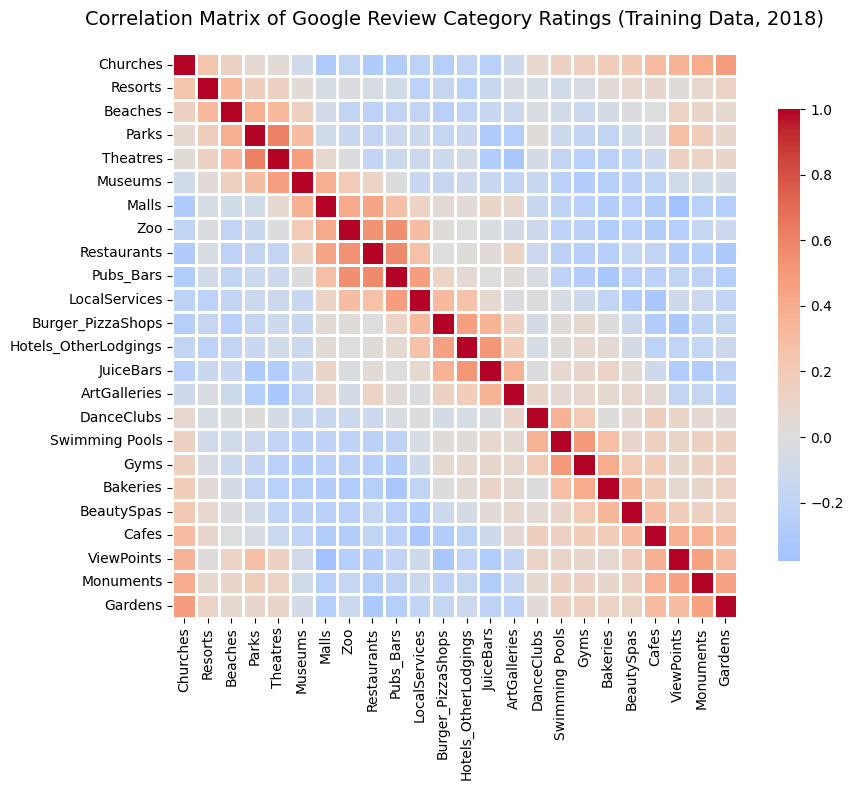

In [8]:
#### UPDATED Correlation Matrix for EDA Section of Report ####

# Compute and visualize pairwise correlations (See V2 below)
# High correlations indicate variables that carry overlapping information

corr_matrix = x_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, # Annotate false versus true removed the numbers from the previous version

            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Google Review Category Ratings (Training Data, 2018)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [9]:
### Step 4: Feature Engineering / Scaling ----

# PCA is variance-sensitive: variables with larger scales will dominate components
# We MUST standardize (mean=0, std=1) before applying PCA

#Impute missing values (fit on train only)
imputer = SimpleImputer(strategy="median")
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed  = imputer.transform(x_test)

# Fit the scaler on training data only
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_test_scaled  = scaler.transform(x_test_imputed)

# Transform both train and test using the fitted scaler
x_train_scaled = pd.DataFrame(x_train_scaled, columns=rating_cols, index=x_train.index)
x_test_scaled  = pd.DataFrame(x_test_scaled, columns=rating_cols, index=x_test.index)

print("Scaled training data:")
print(x_train_scaled.describe())
print("\nNote: All variables now have mean ≈ 0 and std ≈ 1")

Scaled training data:
           Churches       Resorts       Beaches         Parks      Theatres  \
count  3.818000e+03  3.818000e+03  3.818000e+03  3.818000e+03  3.818000e+03   
mean  -8.374652e-18 -7.351084e-17 -4.671195e-16  4.280378e-17  3.024180e-16   
std    1.000131e+00  1.000131e+00  1.000131e+00  1.000131e+00  1.000131e+00   
min   -1.744526e+00 -1.624833e+00 -1.993392e+00 -1.499901e+00 -1.368172e+00   
25%   -6.475497e-01 -6.755564e-01 -7.585725e-01 -8.166175e-01 -8.821997e-01   
50%   -1.516562e-01 -3.056178e-01 -3.416204e-01 -2.484941e-01 -2.093146e-01   
75%    4.313944e-01  2.737198e-01  1.956065e-01  7.687538e-01  1.016832e+00   
max    4.266304e+00  1.865153e+00  2.015763e+00  1.701551e+00  1.532710e+00   

            Museums         Malls           Zoo   Restaurants     Pubs_Bars  \
count  3.818000e+03  3.818000e+03  3.818000e+03  3.818000e+03  3.818000e+03   
mean  -9.026014e-17 -9.677376e-17  8.374652e-17  9.258644e-17 -7.723291e-17   
std    1.000131e+00  1.000131

In [10]:
# What happens when we don't scale?

print("Original (unscaled) variable standard deviations:")
print(x_train.std().sort_values(ascending=False))
print("\nIf we skip scaling, variables with larger variance")
print("will dominate the principal components, even if they're not the most informative.")
print("\nAlways standardize before PCA unless you have a specific reason not to.")

Original (unscaled) variable standard deviations:
ArtGalleries            1.719583
ViewPoints              1.597857
JuiceBars               1.569030
Resorts                 1.432858
Malls                   1.413353
Hotels_OtherLodgings    1.394063
LocalServices           1.384947
Restaurants             1.360479
Theatres                1.337699
Pubs_Bars               1.309278
Parks                   1.302705
Monuments               1.296530
Museums                 1.275924
Beaches                 1.247309
Burger_PizzaShops       1.241924
Bakeries                1.198391
BeautySpas              1.191054
Gardens                 1.152760
Zoo                     1.116374
DanceClubs              1.095437
Swimming Pools          0.960244
Cafes                   0.940038
Gyms                    0.915236
Churches                0.831941
dtype: float64

If we skip scaling, variables with larger variance
will dominate the principal components, even if they're not the most informative.

Always s

In [11]:
### Step 5: PCA - Fit, Interpret, Choose k ----

# Fit PCA on all 24 components first (equal to number of variables)
# We'll examine all components, then decide how many to use for modeling

pca_full = PCA(n_components=24, random_state=RANDOM_SEED)
pca_full.fit(x_train_scaled)

print("PCA fitted on training data.")
print(f"Number of components: {pca_full.n_components}")

PCA fitted on training data.
Number of components: 24


In [12]:
# INTERPRETATION 1: LOADINGS

# Loadings tell us how each original variable contributes to each component
# We'll visualize loadings for all 24 PCs (since we've fit PCA with n_components=24)

loadings = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'pc{i+1}' for i in range(24)],
    index=rating_cols
)

print("\nPrincipal Component Loadings:")
print(loadings.round(3))
print("\nInterpretation:")
print("- Positive loading: category rating increases as you move in the positive direction along this PC")
print("- Negative loading: category rating decreases as you move in the positive direction along this PC")
print("- Larger magnitude: stronger contribution to this component")
print("- Categories with similar loading patterns reflect similar traveler preference signals")


Principal Component Loadings:
                        pc1    pc2    pc3    pc4    pc5    pc6    pc7    pc8  \
Churches             -0.287  0.040  0.154  0.015 -0.193  0.134  0.224  0.233   
Resorts              -0.108  0.148 -0.001 -0.304 -0.118 -0.087  0.664  0.120   
Beaches              -0.129  0.238 -0.229 -0.114  0.038 -0.273  0.365  0.009   
Parks                -0.113  0.339 -0.244  0.167  0.102 -0.188 -0.011  0.038   
Theatres             -0.054  0.379 -0.289  0.154  0.070  0.079 -0.043  0.118   
Museums               0.089  0.331 -0.162 -0.128  0.189  0.347 -0.191  0.153   
Malls                 0.271  0.119  0.032 -0.200  0.157  0.306 -0.056  0.274   
Zoo                   0.270  0.122  0.317  0.023 -0.020  0.250  0.160  0.106   
Restaurants           0.296  0.052  0.340 -0.138  0.020 -0.018  0.014  0.082   
Pubs_Bars             0.291  0.050  0.342  0.157 -0.042 -0.177  0.140  0.012   
LocalServices         0.230 -0.058  0.128  0.464 -0.102 -0.141  0.194 -0.081   
Burger_Pi

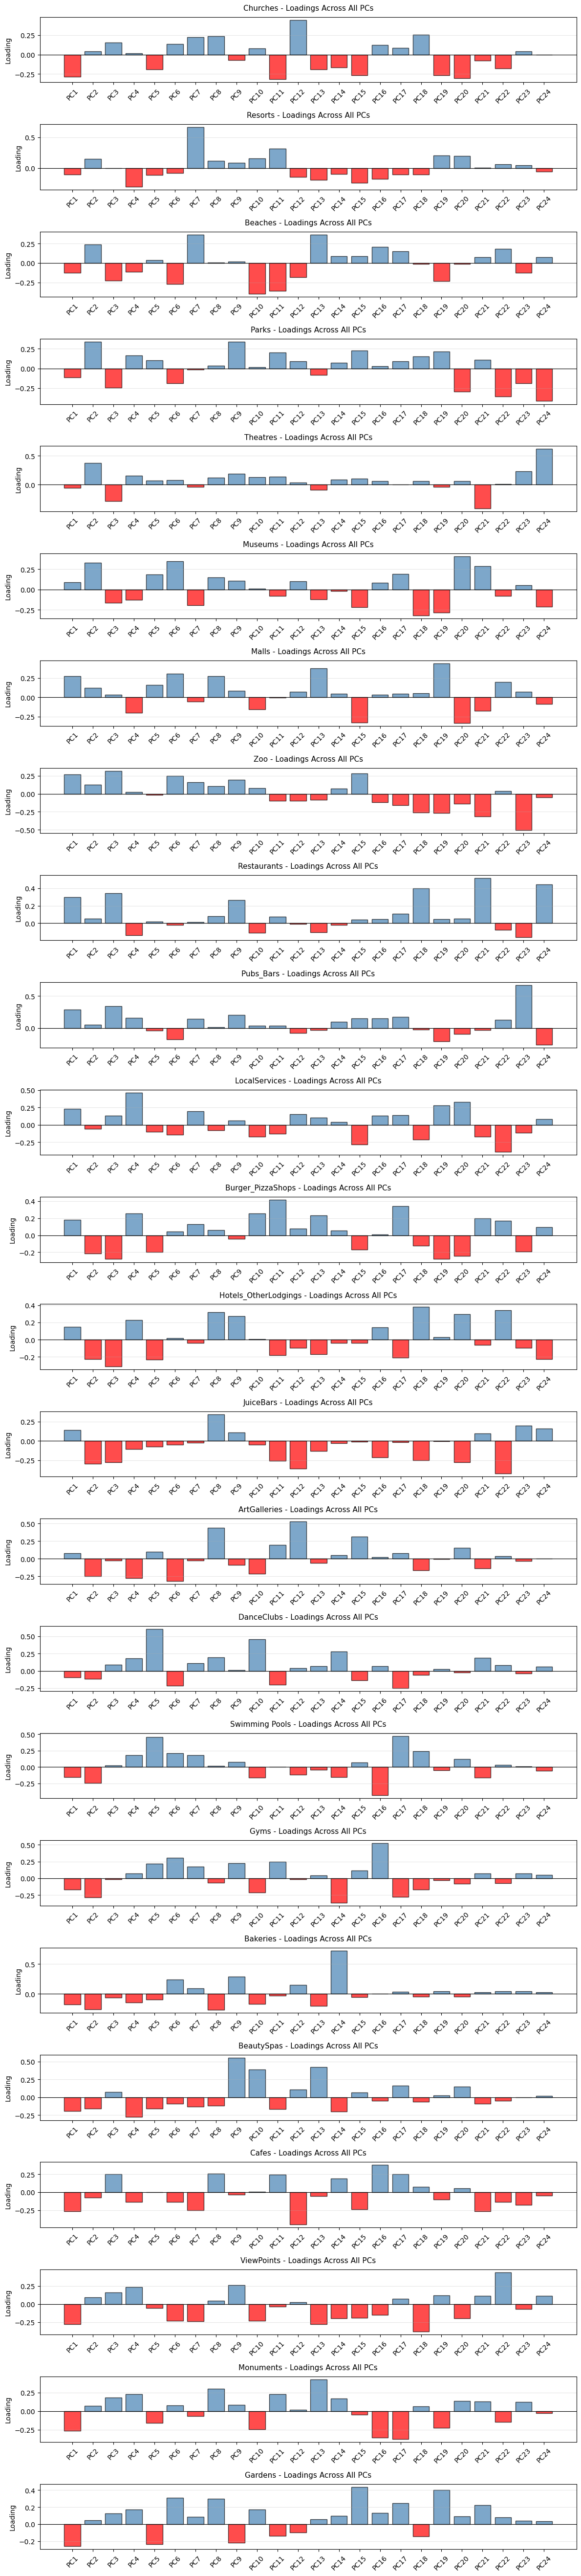


Interpretation:
- Each plot shows how one rating category contributes to all 24 principal components
- Blue bars = positive loading (category rating increases with PC)
- Red bars = negative loading (category rating decreases with PC)
- Taller bars = stronger contribution


In [13]:
# Visualize loadings as bar plots for each variable across all PCs
fig, axes = plt.subplots(len(rating_cols), 1, figsize=(12, 2.2 * len(rating_cols)))

for i, var in enumerate(rating_cols):
    loadings_var = loadings.loc[var, :]
    colors = ['red' if x < 0 else 'steelblue' for x in loadings_var]
    axes[i].bar(range(1, 25), loadings_var, color=colors, alpha=0.7, edgecolor='black')
    axes[i].axhline(0, color='black', linewidth=0.8)
    axes[i].set_ylabel('Loading', fontsize=10)
    axes[i].set_title(f'{var} - Loadings Across All PCs', fontsize=11, pad=10)
    axes[i].set_xticks(range(1, 25))
    axes[i].set_xticklabels([f'PC{j}' for j in range(1, 25)], rotation=45)
    axes[i].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each plot shows how one rating category contributes to all 24 principal components")
print("- Blue bars = positive loading (category rating increases with PC)")
print("- Red bars = negative loading (category rating decreases with PC)")
print("- Taller bars = stronger contribution")

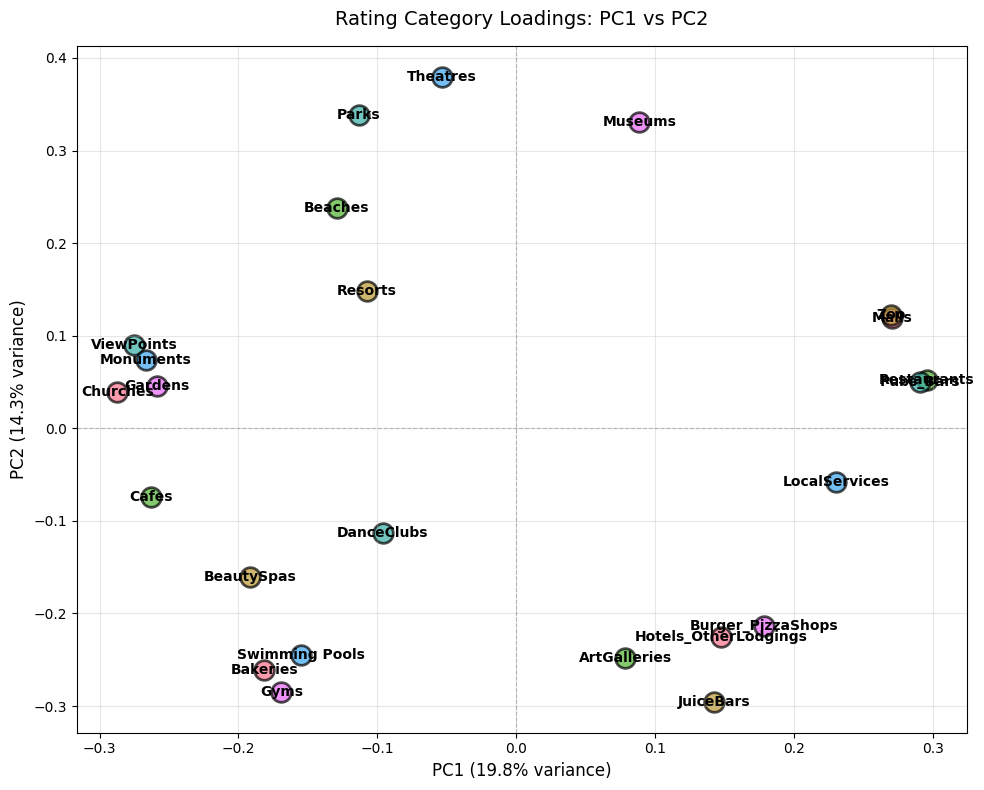


Interpretation:
- Categories close together have similar relationships with PC1 and PC2
- Categories in similar directions are positively correlated
- Categories in opposite directions are negatively correlated
- Distance from origin indicates strength of association with these PCs


In [14]:
# ========================================
# INTERPRETATION 2: LOADINGS SCATTER (PC1 vs PC2)
# ========================================
# Variables as points in PC1-PC2 space
# This shows which variables are similar (point in same direction)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot each rating category as a point
for var in rating_cols:
    ax.scatter(
        loadings.loc[var, 'pc1'],
        loadings.loc[var, 'pc2'],
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidth=2
    )
    ax.text(
        loadings.loc[var, 'pc1'],
        loadings.loc[var, 'pc2'],
        var,
        fontsize=10,
        ha='center',
        va='center',
        fontweight='bold'
    )

ax.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Rating Category Loadings: PC1 vs PC2', fontsize=14, pad=15)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Categories close together have similar relationships with PC1 and PC2")
print("- Categories in similar directions are positively correlated")
print("- Categories in opposite directions are negatively correlated")
print("- Distance from origin indicates strength of association with these PCs")

In [15]:
# ========================================
# INTERPRETATION 3: CONTRIBUTIONS (HEATMAP)
# ========================================
# Contributions tell us how much each variable MATTERS for each component
# More interpretable than raw loadings for "what drives this PC?" questions

# Compute contributions: squared loadings normalized to sum to 1
contributions = pd.DataFrame(
    (pca_full.components_**2 / (pca_full.components_**2).sum(axis=1, keepdims=True)).T,
    columns=[f'pc{i+1}' for i in range(24)],
    index=rating_cols
)

print("\nRating Category Contributions to Each Component:")
print(contributions.round(3))
print("\nNote: Contributions sum to 1.0 for each component (100% of that component's 'budget')")


Rating Category Contributions to Each Component:
                        pc1    pc2    pc3    pc4    pc5    pc6    pc7    pc8  \
Churches              0.082  0.002  0.024  0.000  0.037  0.018  0.050  0.054   
Resorts               0.012  0.022  0.000  0.092  0.014  0.008  0.441  0.014   
Beaches               0.017  0.057  0.053  0.013  0.001  0.075  0.133  0.000   
Parks                 0.013  0.115  0.060  0.028  0.010  0.035  0.000  0.001   
Theatres              0.003  0.144  0.084  0.024  0.005  0.006  0.002  0.014   
Museums               0.008  0.110  0.026  0.016  0.036  0.121  0.036  0.023   
Malls                 0.073  0.014  0.001  0.040  0.025  0.094  0.003  0.075   
Zoo                   0.073  0.015  0.101  0.001  0.000  0.062  0.025  0.011   
Restaurants           0.087  0.003  0.116  0.019  0.000  0.000  0.000  0.007   
Pubs_Bars             0.085  0.003  0.117  0.025  0.002  0.031  0.020  0.000   
LocalServices         0.053  0.003  0.016  0.216  0.010  0.020  0.038 

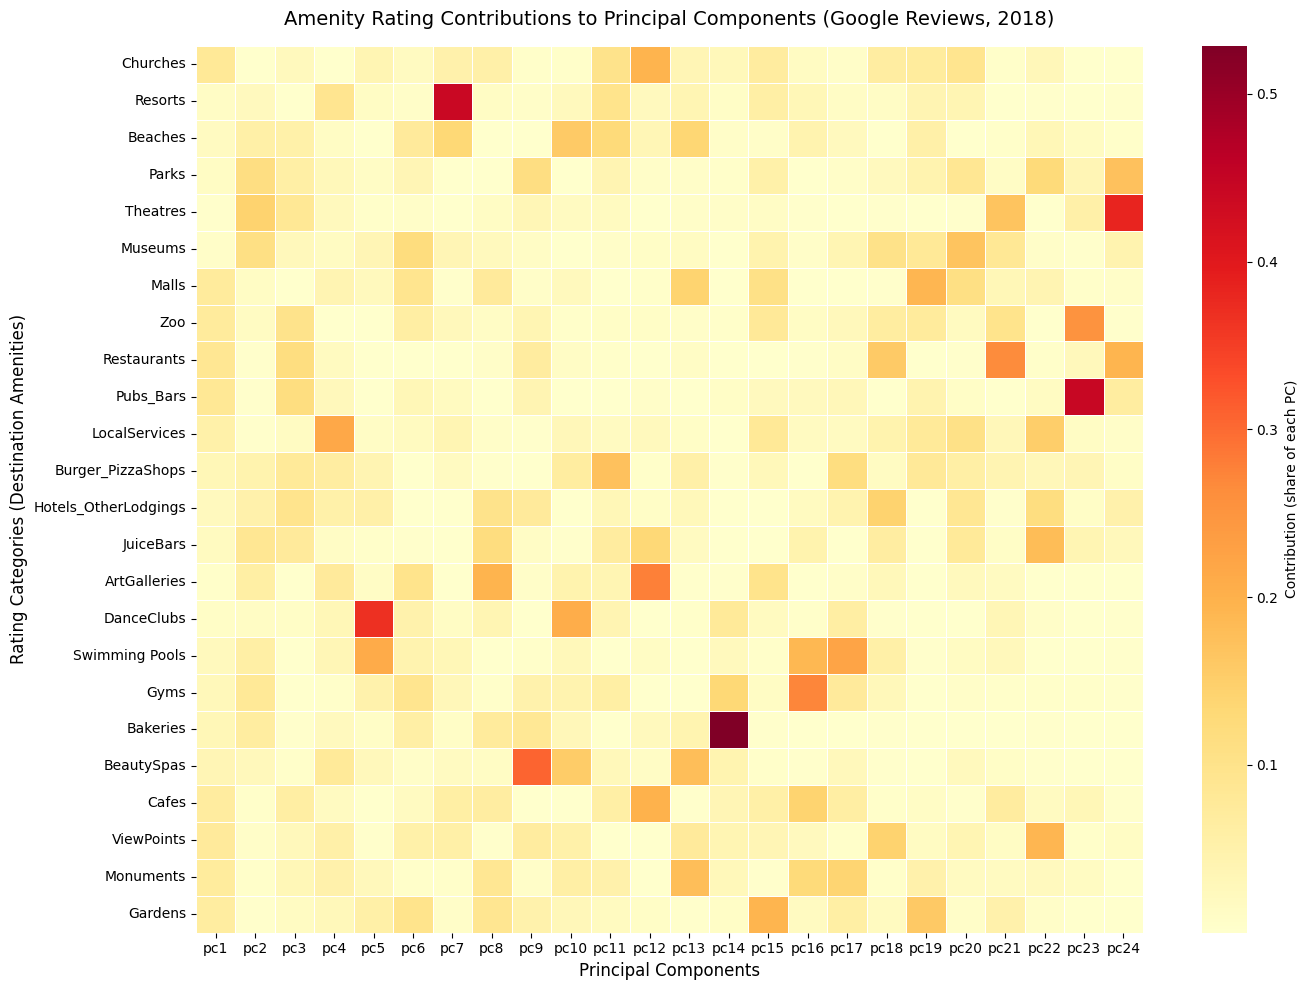


Interpretation:
- Darker colors = higher contribution (that category drives that principal component more)
- Each column sums to 1.0 (100% of that PC)
- Highlights which amenity categories define each latent preference dimension
- Useful for translating PCs into Travelbiz package themes (e.g., nightlife-heavy vs culture-heavy vs nature-heavy)
- Treat 0s carefully: if 0 = 'not visited', consider replacing 0 with NaN and imputing before PCA


In [16]:
# Visualize contributions as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    contributions,
    annot=False,          # 24x24 is too dense to annotate clearly
    fmt='.3f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Contribution (share of each PC)'},
    linewidths=0.5
)
plt.title('Amenity Rating Contributions to Principal Components (Google Reviews, 2018)', fontsize=14, pad=15)
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Rating Categories (Destination Amenities)', fontsize=12)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Darker colors = higher contribution (that category drives that principal component more)")
print("- Each column sums to 1.0 (100% of that PC)")
print("- Highlights which amenity categories define each latent preference dimension")
print("- Useful for translating PCs into Travelbiz package themes (e.g., nightlife-heavy vs culture-heavy vs nature-heavy)")
print("- Treat 0s carefully: if 0 = 'not visited', consider replacing 0 with NaN and imputing before PCA")

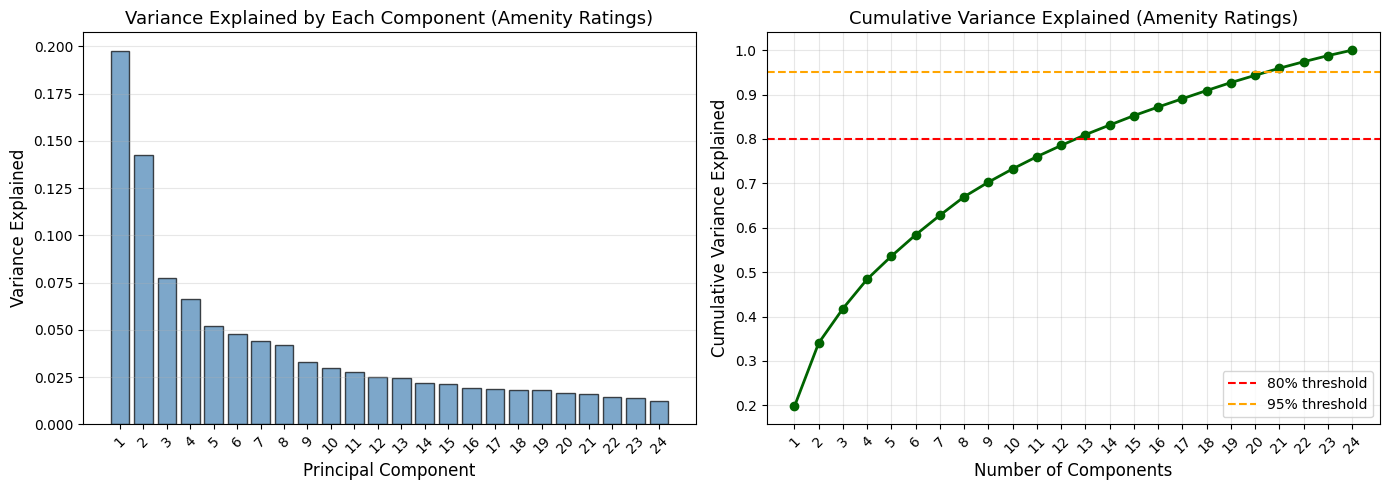

In [17]:
# ========================================
# INTERPRETATION 4: SCREE PLOT
# ========================================
# How many components should we keep?
# Look for the "elbow" and aim for 80-95% cumulative variance as a guideline

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

n_components = len(explained_variance)  # should be 24 for your rating categories

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance explained
axes[0].bar(range(1, n_components + 1), explained_variance, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained', fontsize=12)
axes[0].set_title('Variance Explained by Each Component (Amenity Ratings)', fontsize=13)
axes[0].set_xticks(range(1, n_components + 1))
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3, axis='y')

# Cumulative variance
axes[1].plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-', color='darkgreen', linewidth=2, markersize=6)
axes[1].axhline(y=0.80, color='red', linestyle='--', label='80% threshold', linewidth=1.5)
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% threshold', linewidth=1.5)
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
axes[1].set_title('Cumulative Variance Explained (Amenity Ratings)', fontsize=13)
axes[1].set_xticks(range(1, n_components + 1))
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# ========================================
# INTERPRETATION 5: SCORES (OBSERVATIONS IN PC SPACE)
# ========================================

# Scores are the coordinates of each observation in the PC space
# We'll use the first 3 PCs for our analysis and modeling

n_components_final = 3

# Transform training data using the fitted PCA (24 components)
x_train_pca_full = pca_full.transform(x_train_scaled)

# Extract first 3 components
x_train_pca = x_train_pca_full[:, :n_components_final]

# Convert to DataFrame
scores_train = pd.DataFrame(
    x_train_pca,
    columns=[f'pc{i+1}' for i in range(n_components_final)],
    index=x_train.index
)

print("Training set scores (first 5 users):")
print(scores_train.head())

Training set scores (first 5 users):
           pc1       pc2       pc3
2818 -2.394229  1.015517  1.730944
5194  1.899585  0.191056  0.877907
618   1.890425  0.728902  2.339346
4679  3.242544  0.365342  2.071415
2177  1.378309 -0.261743 -0.676037


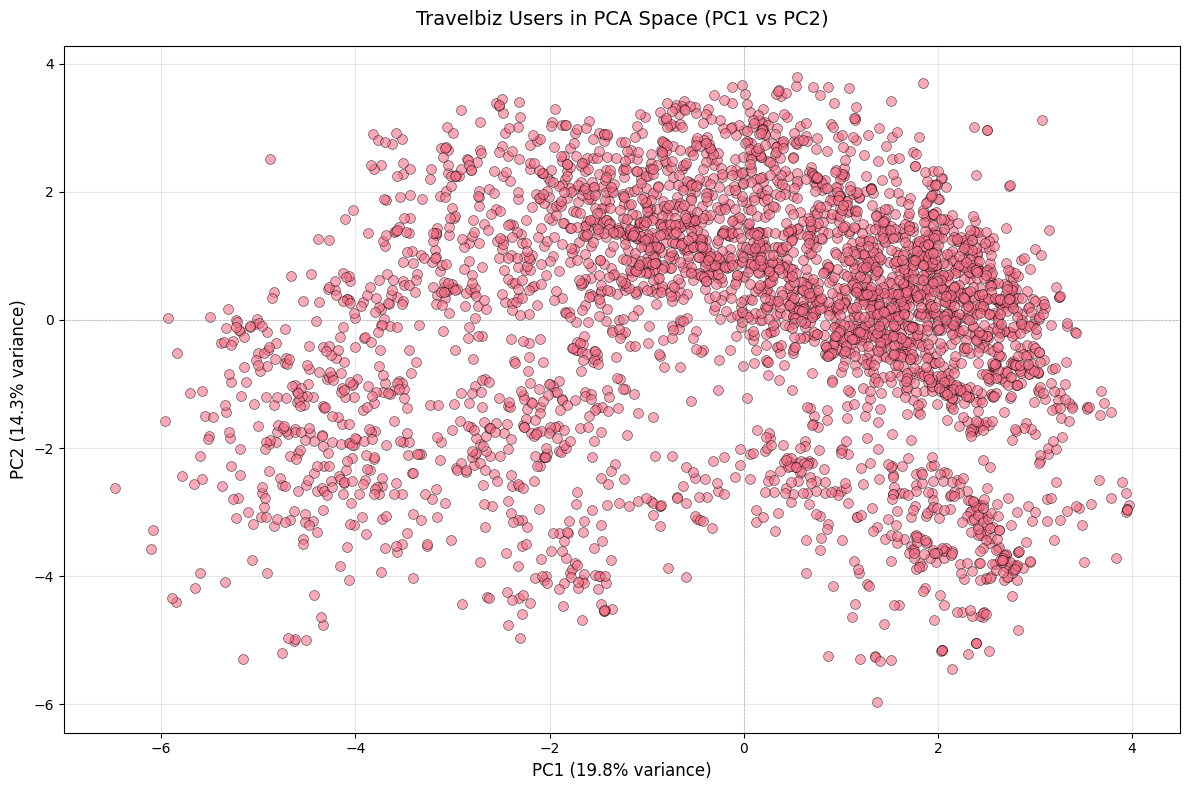

In [19]:
# Visualize users in PC1 vs PC2 space (no group labels available in this Travel dataset)
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(
    scores_train['pc1'],
    scores_train['pc2'],
    alpha=0.6,
    s=50,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Travelbiz Users in PCA Space (PC1 vs PC2)', fontsize=14, pad=15)
ax.axhline(0, color='gray', linewidth=0.5, linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linewidth=0.5, linestyle='--', alpha=0.5)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

cluster
0     474
1    1413
2     681
3    1250
Name: count, dtype: int64


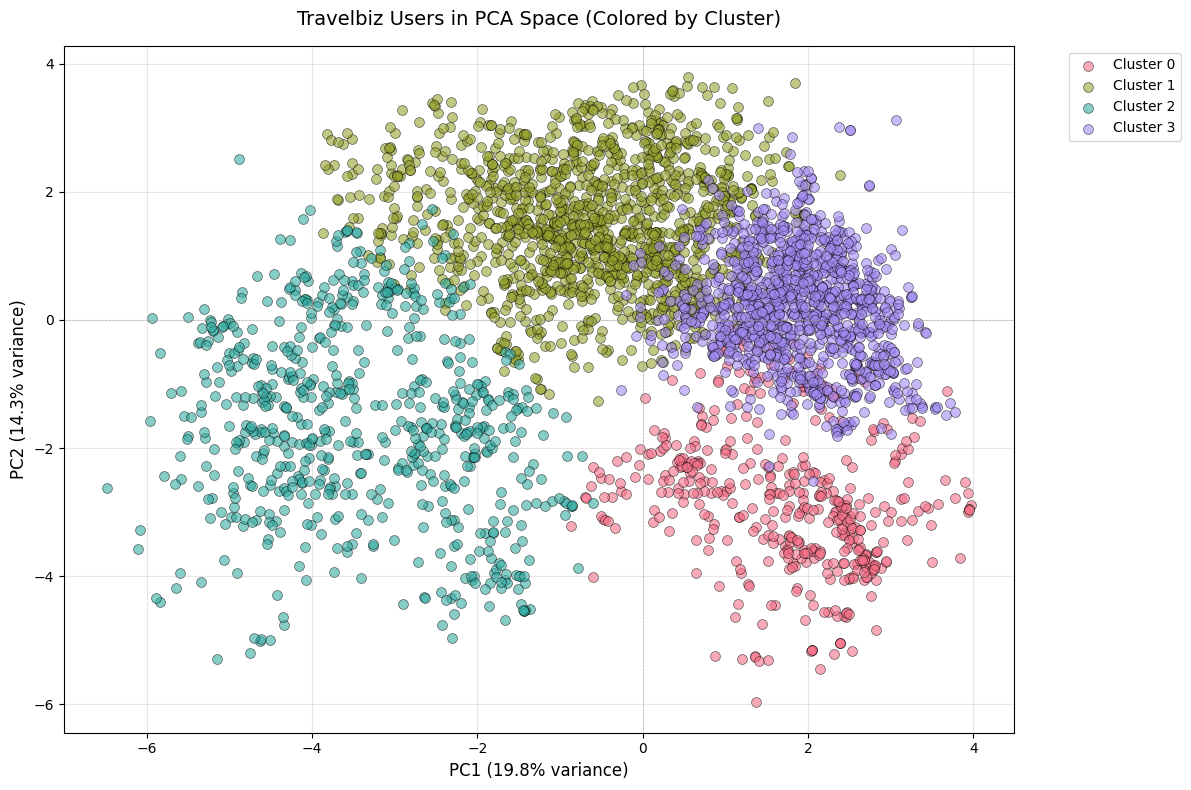

In [20]:
# Visualize users in PC1 vs PC2 space, colored by cluster labels:

k = 4  # example; you can tune this later (elbow/silhouette)
kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)

cluster_train = pd.Series(
    kmeans.fit_predict(scores_train),   # scores_train has pc1, pc2, pc3
    index=scores_train.index,
    name="cluster"
)

print(cluster_train.value_counts().sort_index())
fig, ax = plt.subplots(figsize=(12, 8))

unique_clusters = sorted(cluster_train.unique())
colors = sns.color_palette('husl', n_colors=len(unique_clusters))
cluster_color_map = dict(zip(unique_clusters, colors))

for k in unique_clusters:
    mask = cluster_train == k
    ax.scatter(
        scores_train.loc[mask, 'pc1'],
        scores_train.loc[mask, 'pc2'],
        c=[cluster_color_map[k]],
        label=f"Cluster {k}",
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Travelbiz Users in PCA Space (Colored by Cluster)', fontsize=14, pad=15)
ax.axhline(0, color='gray', linewidth=0.5, linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linewidth=0.5, linestyle='--', alpha=0.5)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# ========================================
# PCA FOR SEGMENTATION: CLUSTERING USERS
# ========================================
# Use the first 3 PC scores as features for clustering (customer segmentation)
# Train Random Forest classifier on PC scores

k = 4  # choose via elbow/silhouette later
kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)

cluster_train = pd.Series(
    kmeans.fit_predict(scores_train),
    index=scores_train.index,
    name="cluster"
)

print("Cluster sizes (training):")
print(cluster_train.value_counts().sort_index())

Cluster sizes (training):
cluster
0     474
1    1413
2     681
3    1250
Name: count, dtype: int64


In [22]:
# ========================================
# PCA FOR PREDICTION: CLUSTER LABEL CLASSIFICATION (PSEUDO-TARGET)
# ========================================
# Predict cluster assignments from PC scores (useful for scoring new users later)

rf_pca = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_pca.fit(scores_train, cluster_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [23]:
### Step 6: Segmentation and final model evaluation ----
# Goal: create customer segments from PCA scores and evaluate them (unsupervised)

# 1) Transform test data into PCA space (same PCA fitted on training)
x_test_pca_full = pca_full.transform(x_test_scaled)
x_test_pca = x_test_pca_full[:, :n_components_final]

scores_test = pd.DataFrame(
    x_test_pca,
    columns=[f'pc{i+1}' for i in range(n_components_final)],
    index=x_test.index
)

# 2) Fit clustering model on TRAIN scores, then assign clusters to both train and test
k_final = 4  # choose via elbow/silhouette + interpretability
kmeans = KMeans(n_clusters=k_final, random_state=RANDOM_SEED, n_init=10)

cluster_train = pd.Series(
    kmeans.fit_predict(scores_train),
    index=scores_train.index,
    name="cluster"
)

cluster_test = pd.Series(
    kmeans.predict(scores_test),
    index=scores_test.index,
    name="cluster"
)

print("Cluster sizes (train):")
print(cluster_train.value_counts().sort_index())
print("\nCluster sizes (test):")
print(cluster_test.value_counts().sort_index())

# 3) Unsupervised evaluation (on TRAIN PCA scores)
sil = silhouette_score(scores_train, cluster_train)
db  = davies_bouldin_score(scores_train, cluster_train)
ch  = calinski_harabasz_score(scores_train, cluster_train)

print("\n" + "-"*80)
print("SEGMENTATION QUALITY METRICS (TRAIN, PCA SCORES)")
print("-"*80)
print(f"Silhouette score (higher better): {sil:.3f}")
print(f"Davies–Bouldin (lower better):    {db:.3f}")
print(f"Calinski–Harabasz (higher better):{ch:.1f}")

# 4) "Accuracy/Precision/Recall" via pseudo-target: predict KMeans cluster labels
# NOTE: This measures consistency of segment assignment, not true business ground-truth accuracy.
rf_cluster = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_cluster.fit(scores_train, cluster_train)

cluster_pred = rf_cluster.predict(scores_test)

acc = accuracy_score(cluster_test, cluster_pred)
prec, rec, f1, sup = precision_recall_fscore_support(
    cluster_test, cluster_pred, average="weighted", zero_division=0
)

print("\n" + "-"*80)
print("SEGMENT ASSIGNMENT CONSISTENCY (RF predicting KMeans clusters)")
print("-"*80)
print(f"Overall Accuracy:  {acc:.3f} ({acc*100:.1f}%)")
print(f"Weighted Precision:{prec:.3f} ({prec*100:.1f}%)")
print(f"Weighted Recall:   {rec:.3f} ({rec*100:.1f}%)")
print("\nClassification report (clusters):")
print(classification_report(cluster_test, cluster_pred, zero_division=0))

# 5) Segment profiles in ORIGINAL amenity rating space (what marketing needs)
profiles_train = x_train.copy()
profiles_train["cluster"] = cluster_train

segment_means = profiles_train.groupby("cluster")[rating_cols].mean().round(2)

print("\n" + "-"*80)
print("SEGMENT PROFILES (MEAN AMENITY RATINGS BY CLUSTER, TRAIN)")
print("-"*80)
print(segment_means)

print("\nTop 5 categories per segment (highest mean ratings):")
for k in sorted(segment_means.index):
    top5 = segment_means.loc[k].sort_values(ascending=False).head(5)
    print(f"\nCluster {k}:")
    print(top5)

Cluster sizes (train):
cluster
0     474
1    1413
2     681
3    1250
Name: count, dtype: int64

Cluster sizes (test):
cluster
0    198
1    634
2    300
3    505
Name: count, dtype: int64

--------------------------------------------------------------------------------
SEGMENTATION QUALITY METRICS (TRAIN, PCA SCORES)
--------------------------------------------------------------------------------
Silhouette score (higher better): 0.391
Davies–Bouldin (lower better):    0.879
Calinski–Harabasz (higher better):2744.0

--------------------------------------------------------------------------------
SEGMENT ASSIGNMENT CONSISTENCY (RF predicting KMeans clusters)
--------------------------------------------------------------------------------
Overall Accuracy:  0.988 (98.8%)
Weighted Precision:0.988 (98.8%)
Weighted Recall:   0.988 (98.8%)

Classification report (clusters):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       198
        

## Distance and Similarity Metrics

We'll compute and compare **Euclidean distance** and **Cosine similarity** on a sample of the training data.
Understanding how these metrics differ is key to choosing the right one for embeddings.

In [24]:
#Feature and Model selection - Distance Comparisons ----

# For visualization clarity, work with a sample of training data
n_sample = 100

sample_idx = np.random.choice(x_train_scaled.shape[0], size=n_sample, replace=False)

X_sample = x_train_scaled.iloc[sample_idx, :]
user_id_sample = user_id_train.iloc[sample_idx]

print(f"Working with a random sample of {n_sample} training users")

Working with a random sample of 100 training users


In [25]:
# ========================================
# METRIC 1: EUCLIDEAN DISTANCE
# ========================================
# Measures straight-line distance in n-dimensional space
# Sensitive to magnitude differences

dist_euclidean = euclidean_distances(X_sample)

print("Euclidean Distance Matrix (Sample Users, Scaled Amenity Ratings):")
print(f"  Shape: {dist_euclidean.shape}")
print(f"  Min distance (excluding diagonal): {dist_euclidean[dist_euclidean > 0].min():.3f}")
print(f"  Max distance: {dist_euclidean.max():.3f}")
print(f"  Mean distance: {dist_euclidean[np.triu_indices_from(dist_euclidean, k=1)].mean():.3f}")

Euclidean Distance Matrix (Sample Users, Scaled Amenity Ratings):
  Shape: (100, 100)
  Min distance (excluding diagonal): 0.475
  Max distance: 11.122
  Mean distance: 6.554


In [26]:
# ========================================
# METRIC 2: COSINE SIMILARITY
# ========================================
# Measures angle between vectors (direction, not magnitude)
# Range: [-1, 1] where 1 = identical direction, -1 = opposite

from sklearn.metrics.pairwise import cosine_similarity

sim_cosine = cosine_similarity(X_sample)

print("Cosine Similarity Matrix (Sample Users, Scaled Amenity Ratings):")
print(f"  Shape: {sim_cosine.shape}")
print(f"  Min similarity (excluding diagonal): {sim_cosine[sim_cosine < 1].min():.3f}")
print(f"  Max similarity: {sim_cosine.max():.3f}")
print(f"  Mean similarity: {sim_cosine[np.triu_indices_from(sim_cosine, k=1)].mean():.3f}")

# Convert to distance for comparison
dist_cosine = 1 - sim_cosine
print(f"\nCosine Distance (1 - similarity):")
print(f"  Min distance (excluding diagonal): {dist_cosine[dist_cosine > 0].min():.3f}")
print(f"  Max distance: {dist_cosine.max():.3f}")
print(f"  Mean distance: {dist_cosine[np.triu_indices_from(dist_cosine, k=1)].mean():.3f}")

Cosine Similarity Matrix (Sample Users, Scaled Amenity Ratings):
  Shape: (100, 100)
  Min similarity (excluding diagonal): -0.669
  Max similarity: 1.000
  Mean similarity: 0.005

Cosine Distance (1 - similarity):
  Min distance (excluding diagonal): 0.000
  Max distance: 1.669
  Mean distance: 0.995


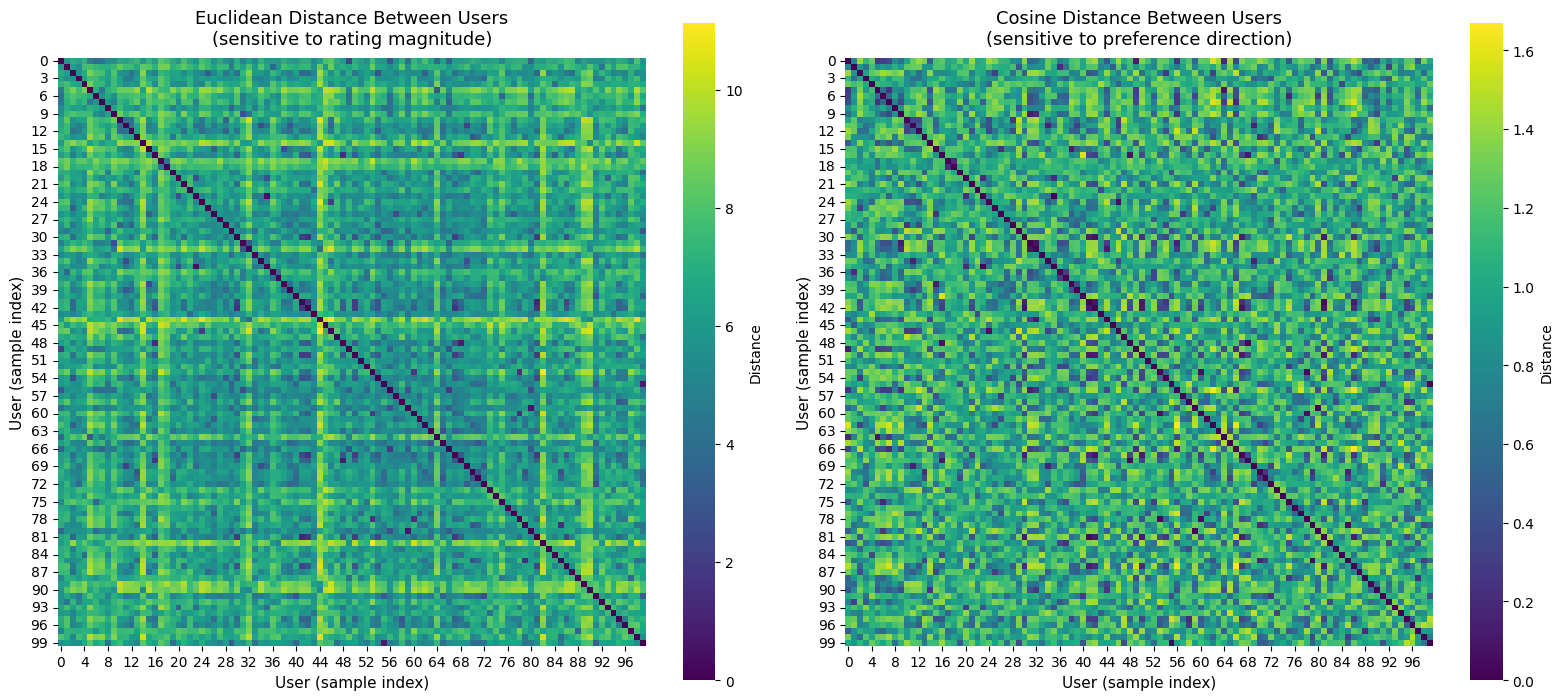


Interpretation:
- Darker colors = smaller distances = more similar users (travel preference patterns)
- Diagonal is always 0 (each user is identical to themselves)
- Euclidean distance emphasizes absolute differences in amenity ratings (overall intensity)
- Cosine distance emphasizes relative patterns across amenities (preference mix), even if users rate higher/lower overall
- For Travelbiz segmentation, cosine can be useful if you care more about 'type of traveler' than 'how generous the rater is'


In [27]:
# Visualize both distance matrices side by side (sample users)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Euclidean distance
sns.heatmap(dist_euclidean, cmap='viridis', square=True, ax=axes[0],
            cbar_kws={'label': 'Distance'})
axes[0].set_title('Euclidean Distance Between Users\n(sensitive to rating magnitude)', fontsize=13, pad=10)
axes[0].set_xlabel('User (sample index)', fontsize=11)
axes[0].set_ylabel('User (sample index)', fontsize=11)

# Cosine distance
sns.heatmap(dist_cosine, cmap='viridis', square=True, ax=axes[1],
            cbar_kws={'label': 'Distance'})
axes[1].set_title('Cosine Distance Between Users\n(sensitive to preference direction)', fontsize=13, pad=10)
axes[1].set_xlabel('User (sample index)', fontsize=11)
axes[1].set_ylabel('User (sample index)', fontsize=11)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Darker colors = smaller distances = more similar users (travel preference patterns)")
print("- Diagonal is always 0 (each user is identical to themselves)")
print("- Euclidean distance emphasizes absolute differences in amenity ratings (overall intensity)")
print("- Cosine distance emphasizes relative patterns across amenities (preference mix), even if users rate higher/lower overall")
print("- For Travelbiz segmentation, cosine can be useful if you care more about 'type of traveler' than 'how generous the rater is'")

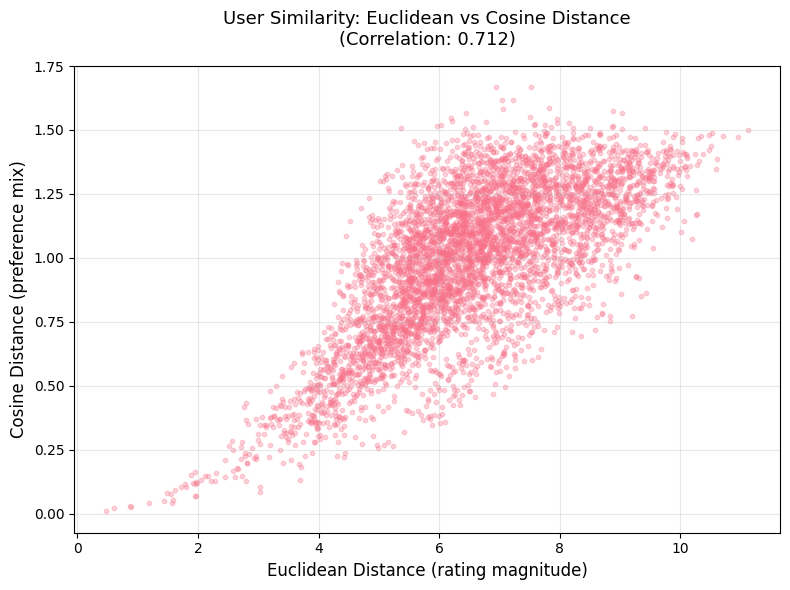


Correlation between Euclidean and Cosine distances: 0.712

Interpretation:
- Moderate correlation: some agreement, but the metrics rank user similarity differently in many cases.

Travelbiz takeaway:
- Euclidean is influenced by how high/low a user rates amenities overall (rating intensity).
- Cosine focuses on *relative preference patterns* across amenities (traveler type).

Next step: visualize whether these choices change the segment shapes using t-SNE and/or UMAP.


In [28]:
# Quantify the correlation between the two distance matrices
# Do they tend to agree on which pairs of users are close/far in preference space?

# Flatten the upper triangles (excluding diagonal) to get pairwise distances
triu_idx = np.triu_indices_from(dist_euclidean, k=1)
euclidean_flat = dist_euclidean[triu_idx]
cosine_flat = dist_cosine[triu_idx]

correlation = np.corrcoef(euclidean_flat, cosine_flat)[0, 1]

# Scatter plot comparing the two metrics
plt.figure(figsize=(8, 6))
plt.scatter(euclidean_flat, cosine_flat, alpha=0.3, s=10)
plt.xlabel('Euclidean Distance (rating magnitude)', fontsize=12)
plt.ylabel('Cosine Distance (preference mix)', fontsize=12)
plt.title(f'User Similarity: Euclidean vs Cosine Distance\n(Correlation: {correlation:.3f})', fontsize=13, pad=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation between Euclidean and Cosine distances: {correlation:.3f}")
print("\nInterpretation:")
if correlation > 0.8:
    print("- High correlation: both metrics mostly agree on which users are similar (clusters likely similar).")
elif correlation > 0.5:
    print("- Moderate correlation: some agreement, but the metrics rank user similarity differently in many cases.")
else:
    print("- Low correlation: the metrics capture meaningfully different notions of 'similar users'.")

print("\nTravelbiz takeaway:")
print("- Euclidean is influenced by how high/low a user rates amenities overall (rating intensity).")
print("- Cosine focuses on *relative preference patterns* across amenities (traveler type).")
print("\nNext step: visualize whether these choices change the segment shapes using t-SNE and/or UMAP.")

---
## Part 2: t-SNE with Different Distance Metrics

t-SNE preserves local neighborhoods. We'll run it with both **Euclidean** and **Cosine** metrics
to see if the choice of metric affects the resulting embedding.

**Reminder:** t-SNE does NOT learn a reusable mapping, so we only work with the training set.

In [29]:
### Step 5 (continued): t-SNE with Euclidean and Cosine ----


print("Fitting t-SNE with Euclidean distance on Travel_Review users...")
print("(This may take a minute)\n")

tsne_euclidean = TSNE(
    n_components=2,
    metric='euclidean',
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=RANDOM_SEED,
    verbose=0
)

X_train_tsne_euclidean = tsne_euclidean.fit_transform(x_train_scaled)

print("t-SNE (Euclidean) complete!")
print(f"  KL divergence: {tsne_euclidean.kl_divergence_:.3f}")
print(f"  Embedding shape: {X_train_tsne_euclidean.shape}")

Fitting t-SNE with Euclidean distance on Travel_Review users...
(This may take a minute)

t-SNE (Euclidean) complete!
  KL divergence: 0.622
  Embedding shape: (3818, 2)


In [30]:
print("Fitting t-SNE with Cosine distance on Travel_Review users...")
print("(This may take a minute)\n")

tsne_cosine = TSNE(
    n_components=2,
    metric='cosine',
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=RANDOM_SEED,
    verbose=0
)

X_train_tsne_cosine = tsne_cosine.fit_transform(x_train_scaled)

print("t-SNE (Cosine) complete!")
print(f"  KL divergence: {tsne_cosine.kl_divergence_:.3f}")
print(f"  Embedding shape: {X_train_tsne_cosine.shape}")

Fitting t-SNE with Cosine distance on Travel_Review users...
(This may take a minute)

t-SNE (Cosine) complete!
  KL divergence: 0.677
  Embedding shape: (3818, 2)


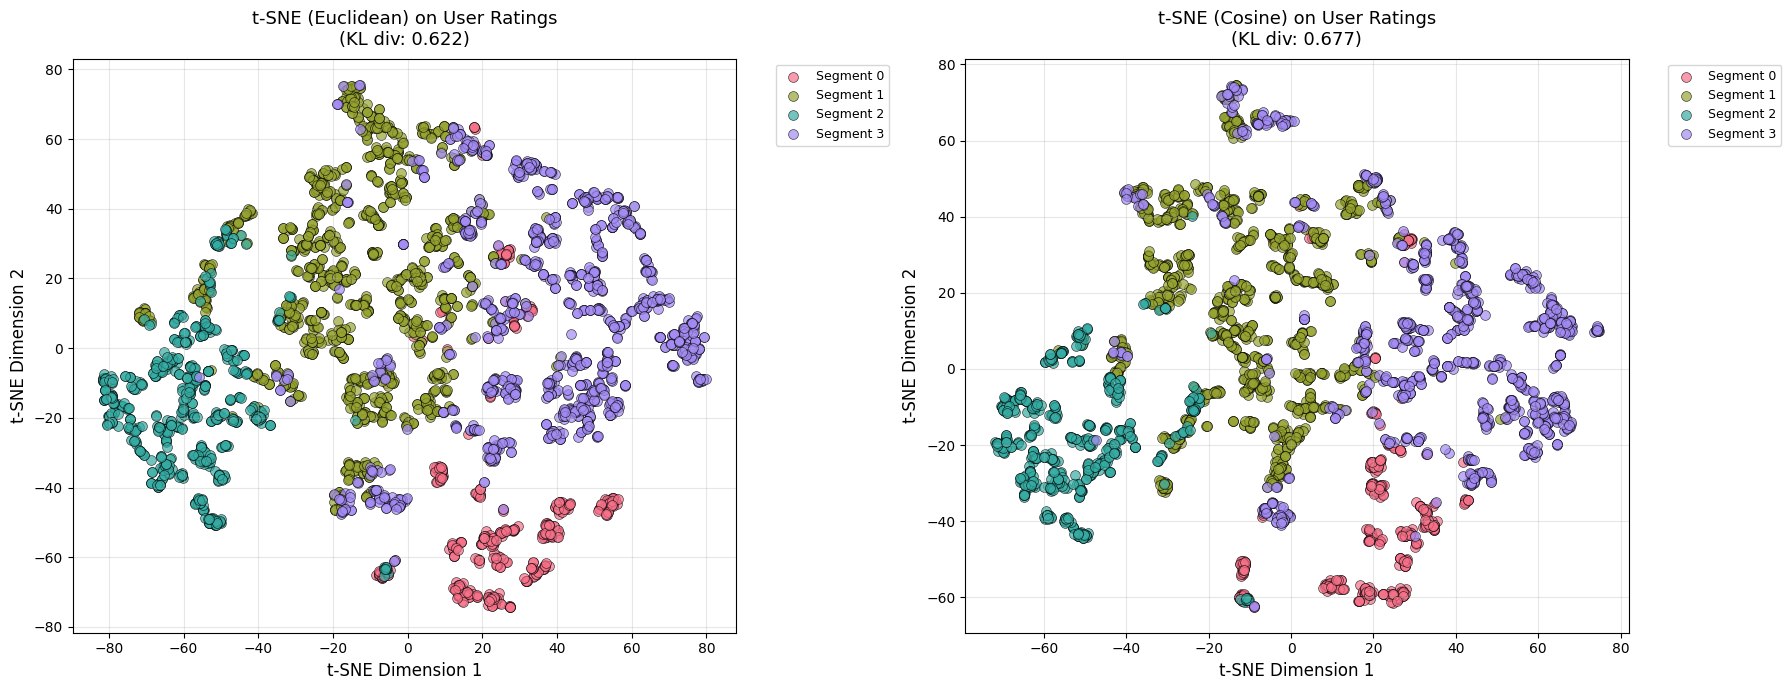


Comparison Questions (Travelbiz Segmentation):
- Do the two embeddings reveal similar segment structure (same groups stay together)?
- Does cosine produce clearer separation of traveler *types* (preference mix) than euclidean?
- If users separate mainly by overall rating intensity, euclidean may separate more than cosine.
- Remember: t-SNE is stochastic; keep random_state fixed and compare patterns, not exact shapes.


In [31]:
# If you haven't created clusters yet, create them from PCA scores (recommended for segmentation)
# (If you already have cluster_train, you can skip this block.)
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=RANDOM_SEED, n_init=10)
cluster_train = pd.Series(kmeans.fit_predict(scores_train), index=scores_train.index, name="cluster")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Unique clusters + colors
unique_clusters = sorted(cluster_train.unique())
colors = sns.color_palette('husl', n_colors=len(unique_clusters))
cluster_color_map = dict(zip(unique_clusters, colors))

# t-SNE with Euclidean
for c in unique_clusters:
    mask = (cluster_train == c).values  # boolean mask aligned to training rows
    axes[0].scatter(
        X_train_tsne_euclidean[mask, 0],
        X_train_tsne_euclidean[mask, 1],
        c=[cluster_color_map[c]],
        label=f"Segment {c}",
        alpha=0.7,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[0].set_title(f't-SNE (Euclidean) on User Ratings\n(KL div: {tsne_euclidean.kl_divergence_:.3f})',
                  fontsize=13, pad=10)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fontsize=9)
axes[0].grid(alpha=0.3)

# t-SNE with Cosine
for c in unique_clusters:
    mask = (cluster_train == c).values
    axes[1].scatter(
        X_train_tsne_cosine[mask, 0],
        X_train_tsne_cosine[mask, 1],
        c=[cluster_color_map[c]],
        label=f"Segment {c}",
        alpha=0.7,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[1].set_title(f't-SNE (Cosine) on User Ratings\n(KL div: {tsne_cosine.kl_divergence_:.3f})',
                  fontsize=13, pad=10)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#we can remove these questions but potentially use it to answer our report:

print("\nComparison Questions (Travelbiz Segmentation):")
print("- Do the two embeddings reveal similar segment structure (same groups stay together)?")
print("- Does cosine produce clearer separation of traveler *types* (preference mix) than euclidean?")
print("- If users separate mainly by overall rating intensity, euclidean may separate more than cosine.")
print("- Remember: t-SNE is stochastic; keep random_state fixed and compare patterns, not exact shapes.")

**Yalda**

In [32]:
df.shape

(5455, 25)

In [33]:
x_train.mean().sort_values(ascending=False)

Malls                   3.351789
Restaurants             3.134673
Theatres                2.949963
Museums                 2.880367
Pubs_Bars               2.841928
Parks                   2.783672
LocalServices           2.552842
Zoo                     2.543017
Beaches                 2.486050
Resorts                 2.327850
ArtGalleries            2.220128
JuiceBars               2.179945
Hotels_OtherLodgings    2.117826
Burger_PizzaShops       2.074002
ViewPoints              1.742750
Gardens                 1.541074
Monuments               1.508724
Churches                1.451152
DanceClubs              1.182954
BeautySpas              1.002695
Bakeries                0.967459
Cafes                   0.966194
Swimming Pools          0.940830
Gyms                    0.805765
dtype: float64

In [34]:
corr_matrix.round(2)

Churches  Resorts  Beaches  Parks  Theatres  Museums  \
Churches                  1.00     0.25     0.15   0.07      0.05    -0.09   
Resorts                   0.25     1.00     0.32   0.17      0.14     0.04   
Beaches                   0.15     0.32     1.00   0.39      0.32     0.15   
Parks                     0.07     0.17     0.39   1.00      0.62     0.30   
Theatres                  0.05     0.14     0.32   0.62      1.00     0.47   
Museums                  -0.09     0.04     0.15   0.30      0.47     1.00   
Malls                    -0.29    -0.05    -0.08  -0.08      0.07     0.38   
Zoo                      -0.20    -0.01    -0.19  -0.14     -0.01     0.21   
Restaurants              -0.29    -0.04    -0.22  -0.18     -0.17     0.12   
Pubs_Bars                -0.28    -0.09    -0.19  -0.13     -0.12    -0.01   
LocalServices            -0.22    -0.22    -0.17  -0.13     -0.13    -0.14   
Burger_PizzaShops        -0.26    -0.16    -0.24  -0.16     -0.11    -0.15   
Hotels_OtherLodgings     -0.18    -0.22    -0.18  -0.14     -0.08    -0.12   
JuiceBars                -0.24    -0.13    -0.14  -0.29     -0.28    -0.14   
ArtGalleries             -0.11    -0.04    -0.12  -0.26     -0.32    -0.19   
DanceClubs                0.08    -0.05    -0.03   0.02     -0.07    -0.15   
Swimming Pools            0.13    -0.08    -0.09  -0.13     -0.19    -0.23   
Gyms                      0.16    -0.03    -0.12  -0.18     -0.24    -0.27   
Bakeries                  0.19     0.03    -0.06  -0.19     -0.25    -0.26   
BeautySpas                0.22     0.08    -0.02  -0.09     -0.20    -0.23   
Cafes                     0.31     0.09    -0.01  -0.04     -0.13    -0.20   
ViewPoints                0.36     0.02     0.13   0.29      0.14    -0.09   
Monuments                 0.41     0.08     0.11   0.18      0.13    -0.09   
Gardens                   0.48     0.12     0.07   0.09      0.10    -0.07   

                      Malls   Zoo  Restaurants  Pubs_Bars  ...  ArtGalleries  \
Churches              -0.29 -0.20        -0.29      -0.28  ...         -0.11   
Resorts               -0.05 -0.01        -0.04      -0.09  ...         -0.04   
Beaches               -0.08 -0.19        -0.22      -0.19  ...         -0.12   
Parks                 -0.08 -0.14        -0.18      -0.13  ...         -0.26   
Theatres               0.07 -0.01        -0.17      -0.12  ...         -0.32   
Museums                0.38  0.21         0.12      -0.01  ...         -0.19   
Malls                  1.00  0.42         0.44       0.28  ...          0.08   
Zoo                    0.42  1.00         0.54       0.55  ...         -0.07   
Restaurants            0.44  0.54         1.00       0.57  ...          0.13   
Pubs_Bars              0.28  0.55         0.57       1.00  ...          0.03   
LocalServices          0.12  0.30         0.27       0.48  ...         -0.02   
Burger_PizzaShops      0.05  0.01        -0.00       0.13  ...          0.14   
Hotels_OtherLodgings   0.04 -0.00         0.02       0.06  ...          0.18   
JuiceBars              0.11 -0.03         0.03      -0.01  ...          0.36   
ArtGalleries           0.08 -0.07         0.13       0.03  ...          1.00   
DanceClubs            -0.14 -0.12        -0.13      -0.03  ...          0.10   
Swimming Pools        -0.21 -0.20        -0.23      -0.21  ...          0.06   
Gyms                  -0.22 -0.23        -0.25      -0.27  ...          0.08   
Bakeries              -0.27 -0.28        -0.26      -0.32  ...          0.07   
BeautySpas            -0.24 -0.25        -0.17      -0.24  ...          0.08   
Cafes                 -0.27 -0.28        -0.18      -0.23  ...          0.06   
ViewPoints            -0.38 -0.26        -0.27      -0.18  ...         -0.17   
Monuments             -0.24 -0.17        -0.26      -0.21  ...         -0.16   
Gardens               -0.26 -0.13        -0.32      -0.26  ...         -0.20   

                      DanceClubs  Swimming Pools  Gyms  Bakeries  Beau

In [35]:
corr_matrix.loc['Restaurants', 'Pubs_Bars']

np.float64(0.5711186145951048)

In [36]:
corr_matrix['Restaurants'].sort_values(ascending=False)

Restaurants             1.000000
Pubs_Bars               0.571119
Zoo                     0.535018
Malls                   0.440831
LocalServices           0.270740
ArtGalleries            0.125925
Museums                 0.124308
JuiceBars               0.031770
Hotels_OtherLodgings    0.017261
Burger_PizzaShops      -0.002563
Resorts                -0.041061
DanceClubs             -0.128826
BeautySpas             -0.167061
Theatres               -0.173668
Parks                  -0.176457
Cafes                  -0.183924
Beaches                -0.217164
Swimming Pools         -0.225452
Gyms                   -0.253005
Monuments              -0.255850
Bakeries               -0.263496
ViewPoints             -0.267400
Churches               -0.288173
Gardens                -0.317993
Name: Restaurants, dtype: float64

In [37]:
df.columns


Index(['UserID', 'Churches', 'Resorts', 'Beaches', 'Parks', 'Theatres',
       'Museums', 'Malls', 'Zoo', 'Restaurants', 'Pubs_Bars', 'LocalServices',
       'Burger_PizzaShops', 'Hotels_OtherLodgings', 'JuiceBars',
       'ArtGalleries', 'DanceClubs', 'Swimming Pools', 'Gyms', 'Bakeries',
       'BeautySpas', 'Cafes', 'ViewPoints', 'Monuments', 'Gardens'],
      dtype='object')

In [38]:
(df == 0).sum().sum()


np.int64(5319)

In [39]:
#Plot 3: UMAP ---

import umap

print("Fitting UMAP with Euclidean distance...")
print("(UMAP is faster than t-SNE)\n")

umap_euclidean = umap.UMAP(
    n_components=2,
    metric="euclidean",
    n_neighbors=15,
    min_dist=0.1,
    random_state=RANDOM_SEED,
    verbose=False
)

X_train_umap_euclidean = umap_euclidean.fit_transform(x_train_scaled)
X_test_umap_euclidean  = umap_euclidean.transform(x_test_scaled)

print("UMAP (Euclidean) complete!")
print(f"  Training embedding shape: {X_train_umap_euclidean.shape}")
print(f"  Test embedding shape:     {X_test_umap_euclidean.shape}\n")


print("Fitting UMAP with Cosine distance...\n")

umap_cosine = umap.UMAP(
    n_components=2,
    metric="cosine",
    n_neighbors=15,
    min_dist=0.1,
    random_state=RANDOM_SEED,
    verbose=False
)

X_train_umap_cosine = umap_cosine.fit_transform(x_train_scaled)
X_test_umap_cosine  = umap_cosine.transform(x_test_scaled)

print("UMAP (Cosine) complete!")
print(f"  Training embedding shape: {X_train_umap_cosine.shape}")
print(f"  Test embedding shape:     {X_test_umap_cosine.shape}")

Fitting UMAP with Euclidean distance...
(UMAP is faster than t-SNE)



/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP (Euclidean) complete!
  Training embedding shape: (3818, 2)
  Test embedding shape:     (1637, 2)

Fitting UMAP with Cosine distance...



/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP (Cosine) complete!
  Training embedding shape: (3818, 2)
  Test embedding shape:     (1637, 2)


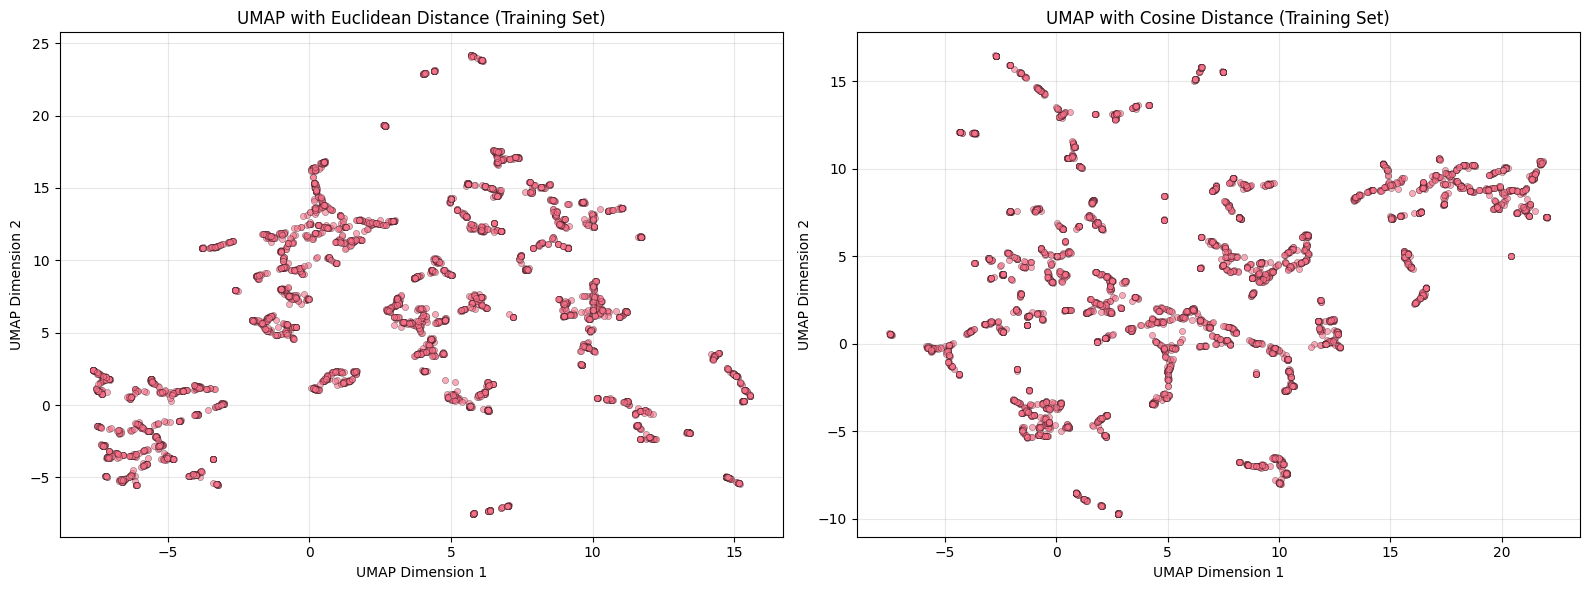


Comparison Questions:
- Do the two embeddings reveal similar grouping patterns?
- Does one metric produce clearer local separation?


In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Euclidean
axes[0].scatter(X_train_umap_euclidean[:, 0], X_train_umap_euclidean[:, 1],
                alpha=0.6, s=20, edgecolors="black", linewidth=0.3)
axes[0].set_title("UMAP with Euclidean Distance (Training Set)")
axes[0].set_xlabel("UMAP Dimension 1")
axes[0].set_ylabel("UMAP Dimension 2")
axes[0].grid(alpha=0.3)

# Cosine
axes[1].scatter(X_train_umap_cosine[:, 0], X_train_umap_cosine[:, 1],
                alpha=0.6, s=20, edgecolors="black", linewidth=0.3)
axes[1].set_title("UMAP with Cosine Distance (Training Set)")
axes[1].set_xlabel("UMAP Dimension 1")
axes[1].set_ylabel("UMAP Dimension 2")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison Questions:")
print("- Do the two embeddings reveal similar grouping patterns?")
print("- Does one metric produce clearer local separation?")

CLUSTERING PART 1- DILLON

In [41]:
scores_train.describe().round(1)

pc1     pc2     pc3
count  3818.0  3818.0  3818.0
mean      0.0    -0.0    -0.0
std       2.2     1.9     1.4
min      -6.5    -6.0    -4.2
25%      -1.5    -1.1    -1.0
50%       0.4     0.3    -0.2
75%       1.8     1.3     1.0
max       4.0     3.8     3.7

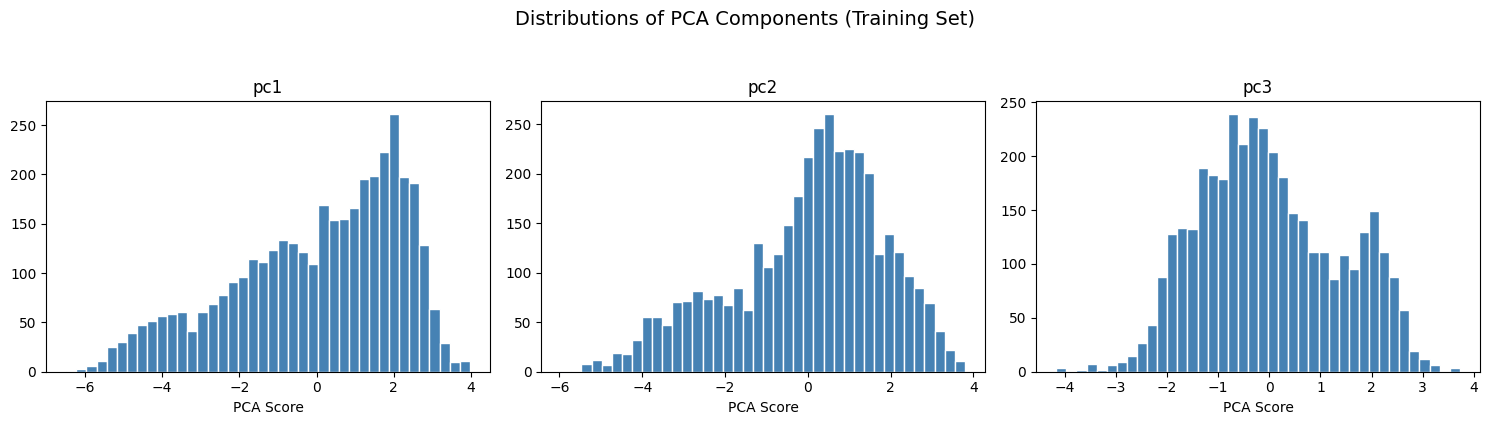

In [42]:
# Distribution of each PCA component
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, scores_train.columns):
    ax.hist(scores_train[col], bins=40, edgecolor="white", color="steelblue")
    ax.set_title(col)
    ax.set_xlabel("PCA Score")

fig.suptitle("Distributions of PCA Components (Training Set)", fontsize=14, y=1.05)
fig.tight_layout()
plt.show()


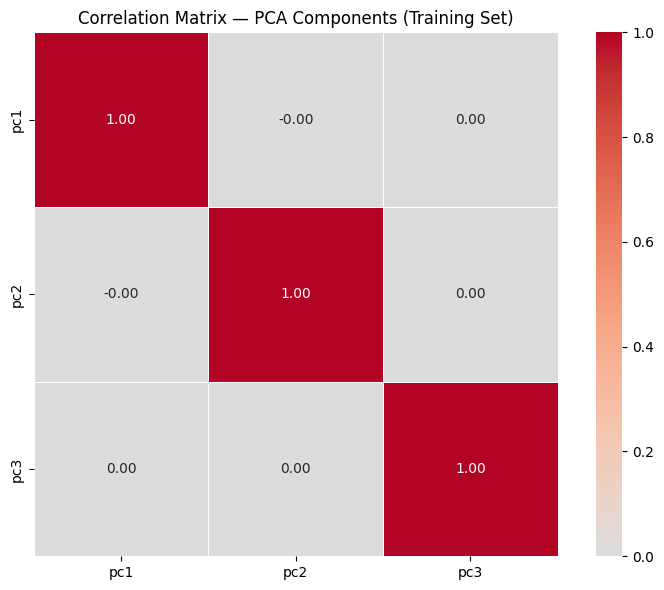

In [43]:
# Correlation matrix
corr = scores_train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix — PCA Components (Training Set)")
plt.tight_layout()
plt.show()


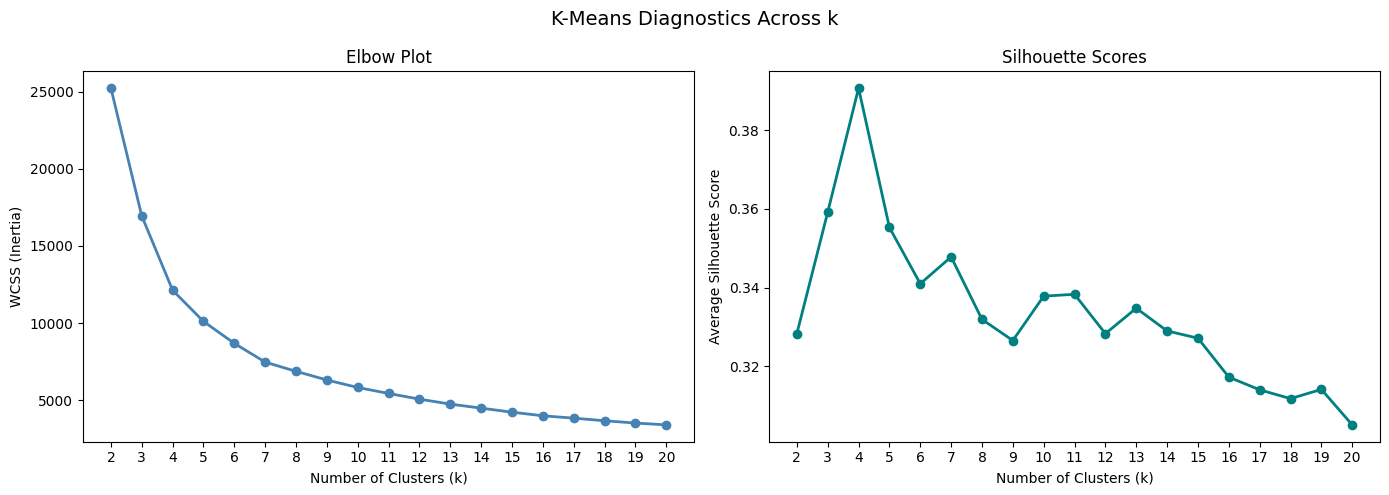

In [44]:
### Step 5a: K-Means -- search over k ---- CLUSTERING APPROACH: K-MEANS, SILOHOUETTE, STABILITY RESAMPLING, AND HIERARCHICAL CLUSTERING

K_range = range(2, 21)
wcss_scores = []
sil_scores  = []

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_SEED)
    labels = km.fit_predict(scores_train)
    wcss_scores.append(km.inertia_)
    sil_scores.append(silhouette_score(scores_train, labels))

# Plot both diagnostics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, wcss_scores, "o-", color="steelblue", linewidth=2)
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("WCSS (Inertia)")
ax1.set_title("Elbow Plot")
ax1.set_xticks(list(K_range))

ax2.plot(K_range, sil_scores, "o-", color="teal", linewidth=2)
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Average Silhouette Score")
ax2.set_title("Silhouette Scores")
ax2.set_xticks(list(K_range))

fig.suptitle("K-Means Diagnostics Across k", fontsize=14)
fig.tight_layout()
plt.show()


In [45]:
# ---- Choose your candidate k here ----
k_chosen = 5

print(f"Selected k = {k_chosen}")
print(f"  WCSS:       {wcss_scores[k_chosen - 2]:.1f}")
print(f"  Silhouette: {sil_scores[k_chosen - 2]:.4f}")


Selected k = 5
  WCSS:       10106.6
  Silhouette: 0.3553


In [46]:
### CLUSTER COUNTS ----FOR RECOS
km_final = KMeans(n_clusters=k_chosen, n_init=20, random_state=RANDOM_SEED)
train_labels = km_final.fit_predict(scores_train)

print("Final model fitted.")
print("Cluster counts:", np.bincount(train_labels))


Final model fitted.
Cluster counts: [ 453  723  959 1108  575]


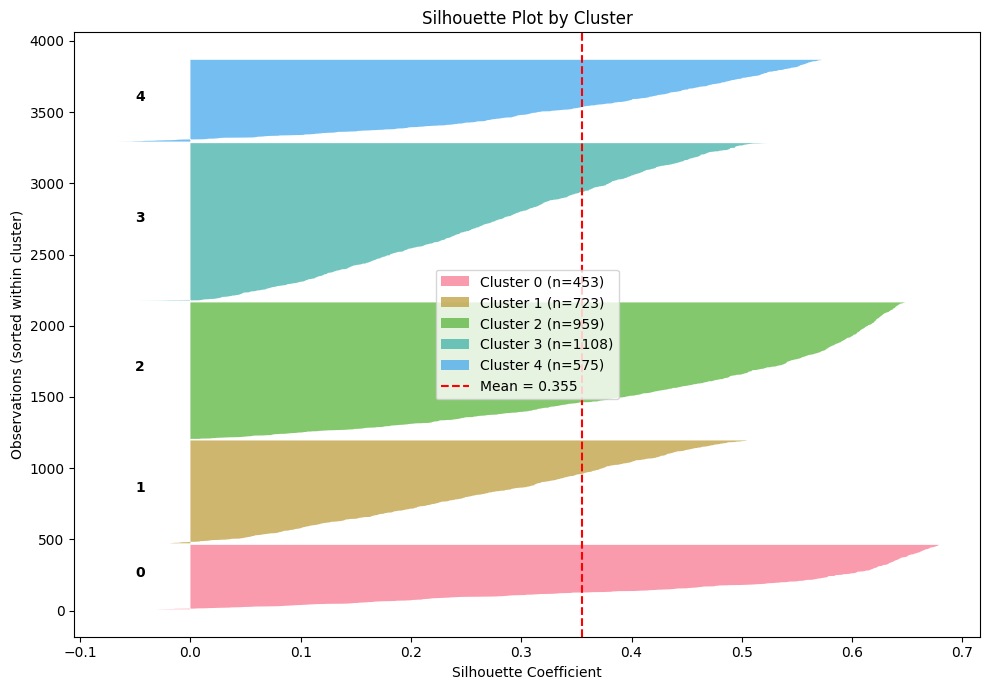

Points with negative silhouette: 36 / 3818 (0.9%)


In [47]:
# Silhouette plot by cluster
sil_vals = silhouette_samples(scores_train, train_labels)
avg_sil  = sil_vals.mean()

fig, ax = plt.subplots(figsize=(10, 7))
y_lower = 10

for i in range(k_chosen):
    cluster_sil = np.sort(sil_vals[train_labels == i])
    size_i = cluster_sil.shape[0]
    y_upper = y_lower + size_i

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_sil,
        alpha=0.7,
        label=f"Cluster {i} (n={size_i})"
    )
    ax.text(-0.05, y_lower + 0.5 * size_i, str(i), fontweight="bold")
    y_lower = y_upper + 10

ax.axvline(avg_sil, color="red", linestyle="--", label=f"Mean = {avg_sil:.3f}")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Observations (sorted within cluster)")
ax.set_title("Silhouette Plot by Cluster")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

# Points with negative silhouette
n_neg = (sil_vals < 0).sum()
print(f"Points with negative silhouette: {n_neg} / {len(sil_vals)} ({100*n_neg/len(sil_vals):.1f}%)")


Stability (ARI) over 30 runs:
  Mean:   0.912
  Std:    0.104
  Min:    0.666
  Max:    0.996


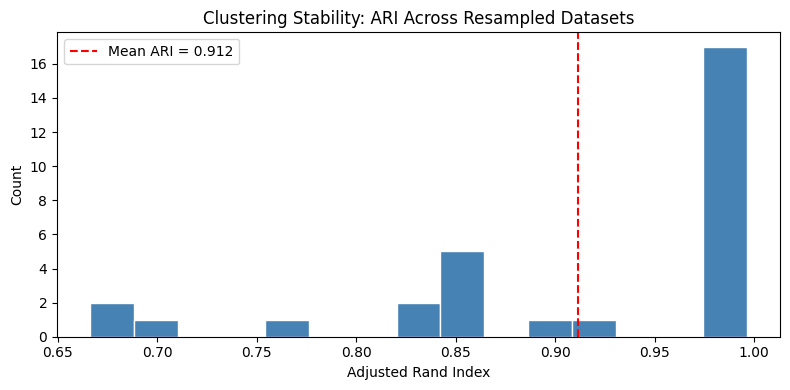

In [48]:
### Stability check via resampling ----

B = 30  # number of perturbations
ari_scores = []

for b in range(B):
    # Sample 80% of training data without replacement
    idx = np.random.choice(scores_train.index, size=int(0.8 * len(scores_train)),
                           replace=False)
    X_sub = scores_train.loc[idx]

    # Re-fit K-Means
    km_sub = KMeans(n_clusters=k_chosen, n_init=20, random_state=b)
    sub_labels = km_sub.fit_predict(X_sub)

    # Compare to reference labels for the same observations
    ref_labels = pd.Series(train_labels, index=scores_train.index).loc[idx].values
    ari = adjusted_rand_score(ref_labels, sub_labels)
    ari_scores.append(ari)

print(f"Stability (ARI) over {B} runs:")
print(f"  Mean:   {np.mean(ari_scores):.3f}")
print(f"  Std:    {np.std(ari_scores):.3f}")
print(f"  Min:    {np.min(ari_scores):.3f}")
print(f"  Max:    {np.max(ari_scores):.3f}")

plt.figure(figsize=(8, 4))
plt.hist(ari_scores, bins=15, edgecolor="white", color="steelblue")
plt.axvline(np.mean(ari_scores), color="red", linestyle="--",
            label=f"Mean ARI = {np.mean(ari_scores):.3f}")
plt.xlabel("Adjusted Rand Index")
plt.ylabel("Count")
plt.title("Clustering Stability: ARI Across Resampled Datasets")
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
# Predict cluster membership on the test set
test_labels = km_final.predict(scores_test)

# Silhouette on train vs. test
sil_train = silhouette_score(scores_train, train_labels)
sil_test  = silhouette_score(scores_test, test_labels)

print(f"Silhouette -- Training: {sil_train:.4f}")
print(f"Silhouette -- Test:     {sil_test:.4f}")

print("\nTest set cluster sizes:")
print(pd.Series(test_labels).value_counts().sort_index())


Silhouette -- Training: 0.3553
Silhouette -- Test:     0.3606

Test set cluster sizes:
0    191
1    307
2    394
3    488
4    257
Name: count, dtype: int64


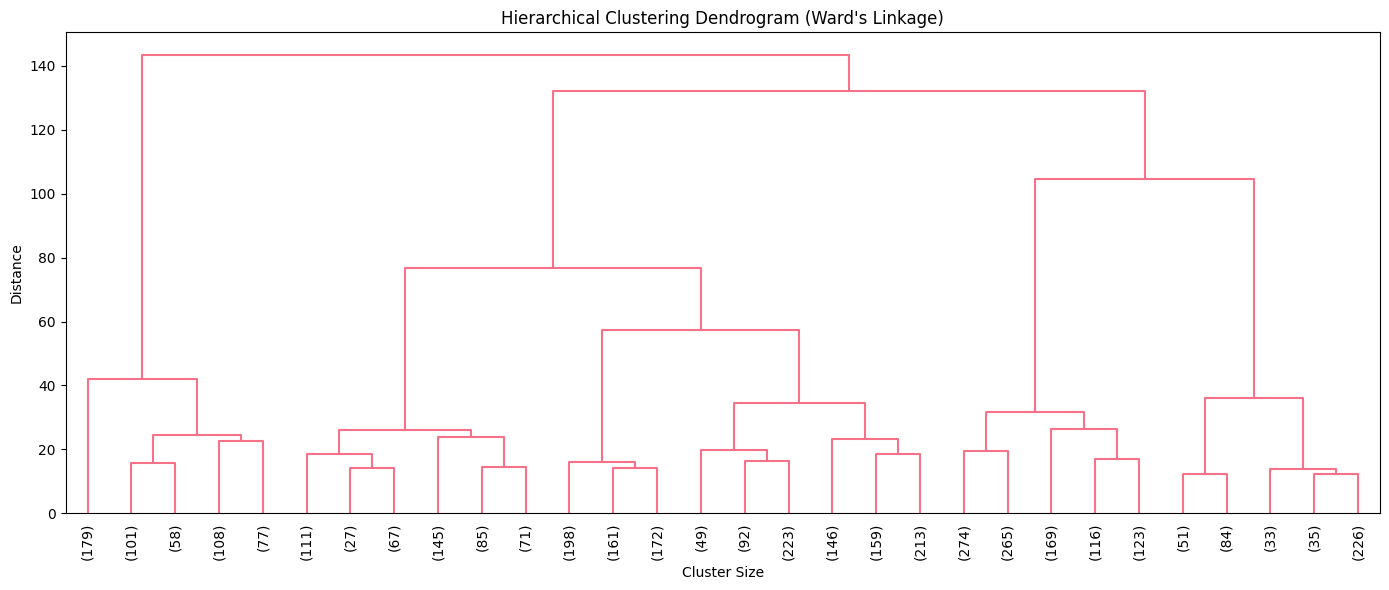

In [50]:
### Step 5b: Hierarchical clustering ----

# Compute linkage matrix (Ward's method)
Z = linkage(scores_train, method="ward")

# Dendrogram
plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    truncate_mode="lastp",
    p=30,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0
)
plt.title("Hierarchical Clustering Dendrogram (Ward's Linkage)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [51]:
from sklearn.cluster import AgglomerativeClustering

# Cut at the same k and compare to K-Means
hc = AgglomerativeClustering(n_clusters=k_chosen, linkage="ward")
hc_labels = hc.fit_predict(scores_train)

ari_hc = adjusted_rand_score(train_labels, hc_labels)
print(f"ARI between K-Means and Hierarchical (Ward's): {ari_hc:.3f}")

# Crosstab of assignments
print("\nCrosstab of K-Means vs. Hierarchical assignments:")
print(pd.crosstab(
    pd.Series(train_labels, name="K-Means"),
    pd.Series(hc_labels, name="Hierarchical")
))

ARI between K-Means and Hierarchical (Ward's): 0.721

Crosstab of K-Means vs. Hierarchical assignments:
Hierarchical     0    1    2    3    4
K-Means                               
0               45    0  405    3    0
1              254    3    0    0  466
2               50    0    1  908    0
3             1064    1    0   36    7
4                0  519   23    0   33


CLUSTER PART 2 - VICTOR: Cluster profiling, PCA projection, logistic regression, cluster naming and recos.



In [52]:
### Step 6a: Cluster profiling ----

# Standardized (mean=0, std=1) version of the ratings and average per cluster
# Means of SCALED features by cluster
profile = x_train_scaled.copy()
profile["Cluster"] = train_labels

cluster_means = profile.groupby("Cluster")[rating_cols].mean()
print("Cluster centers (standardized features):")
display(cluster_means.round(3))

Cluster centers (standardized features):


Churches  Resorts  Beaches  Parks  Theatres  Museums  Malls    Zoo  \
Cluster                                                                       
0          -0.840   -0.895   -0.669 -0.839    -0.900   -0.836 -0.113 -0.477   
1           0.487    0.322    0.621  0.891     0.650    0.084 -0.507 -0.475   
2          -0.333   -0.186   -0.514 -0.539    -0.532   -0.033  0.538  1.136   
3          -0.216    0.279    0.393  0.507     0.788    0.760  0.446 -0.041   
4           1.022    0.073   -0.153 -0.537    -0.740   -0.857 -1.029 -0.843   

         Restaurants  Pubs_Bars  ...  ArtGalleries  DanceClubs  \
Cluster                          ...                             
0             -0.173      0.041  ...         0.945       0.073   
1             -0.488     -0.465  ...        -0.540      -0.109   
2              1.141      1.094  ...         0.005      -0.180   
3             -0.092     -0.191  ...        -0.151      -0.139   
4             -0.977     -0.903  ...         0.217       0.648   

         Swimming Pools   Gyms  Bakeries  BeautySpas  Cafes  ViewPoints  \
Cluster                                                                   
0                 0.061  0.060     0.144      -0.013 -0.320      -0.675   
1                -0.124 -0.106    -0.060       0.168  0.154       0.813   
2                -0.319 -0.375    -0.398      -0.332 -0.296      -0.348   
3                -0.287 -0.323    -0.345      -0.329 -0.302      -0.303   
4                 1.194  1.335     1.289       0.986  1.135       0.675   

         Monuments  Gardens  
Cluster                      
0           -0.663   -0.688  
1            0.742    0.463  
2           -0.351   -0.352  
3           -0.321   -0.169  
4            0.793    0.873  

[5 rows x 24 columns]

In [53]:
# Modified cluster profiles in original rating units
# Example: Cluster 2 rates Restaurants 4.69 and Pubs/Bars 4.27, the highest of any cluster for both. They also rate Malls at 4.11; dining-and-entertainment segment.
# START PROFILING HERE
profile_orig = x_train.copy()
profile_orig["Cluster"] = train_labels
cluster_means_orig = profile_orig.groupby("Cluster")[rating_cols].mean()
print("Cluster means in original rating units:")
display(cluster_means_orig.round(2))

Cluster means in original rating units:


Churches  Resorts  Beaches  Parks  Theatres  Museums  Malls   Zoo  \
Cluster                                                                      
0            0.75     1.05     1.65   1.69      1.75     1.81   3.19  2.01   
1            1.86     2.79     3.26   3.94      3.82     2.99   2.63  2.01   
2            1.17     2.06     1.85   2.08      2.24     2.84   4.11  3.81   
3            1.27     2.73     2.98   3.44      4.00     3.85   3.98  2.50   
4            2.30     2.43     2.30   2.08      1.96     1.79   1.90  1.60   

         Restaurants  Pubs_Bars  ...  ArtGalleries  DanceClubs  \
Cluster                          ...                             
0               2.90       2.90  ...          3.84        1.26   
1               2.47       2.23  ...          1.29        1.06   
2               4.69       4.27  ...          2.23        0.99   
3               3.01       2.59  ...          1.96        1.03   
4               1.81       1.66  ...          2.59        1.89   

         Swimming Pools  Gyms  Bakeries  BeautySpas  Cafes  ViewPoints  \
Cluster                                                                  
0                  1.00  0.86      1.14        0.99   0.67        0.66   
1                  0.82  0.71      0.90        1.20   1.11        3.04   
2                  0.63  0.46      0.49        0.61   0.69        1.19   
3                  0.67  0.51      0.55        0.61   0.68        1.26   
4                  2.09  2.03      2.51        2.18   2.03        2.82   

         Monuments  Gardens  
Cluster                      
0             0.65     0.75  
1             2.47     2.07  
2             1.05     1.14  
3             1.09     1.35  
4             2.54     2.55  

[5 rows x 24 columns]

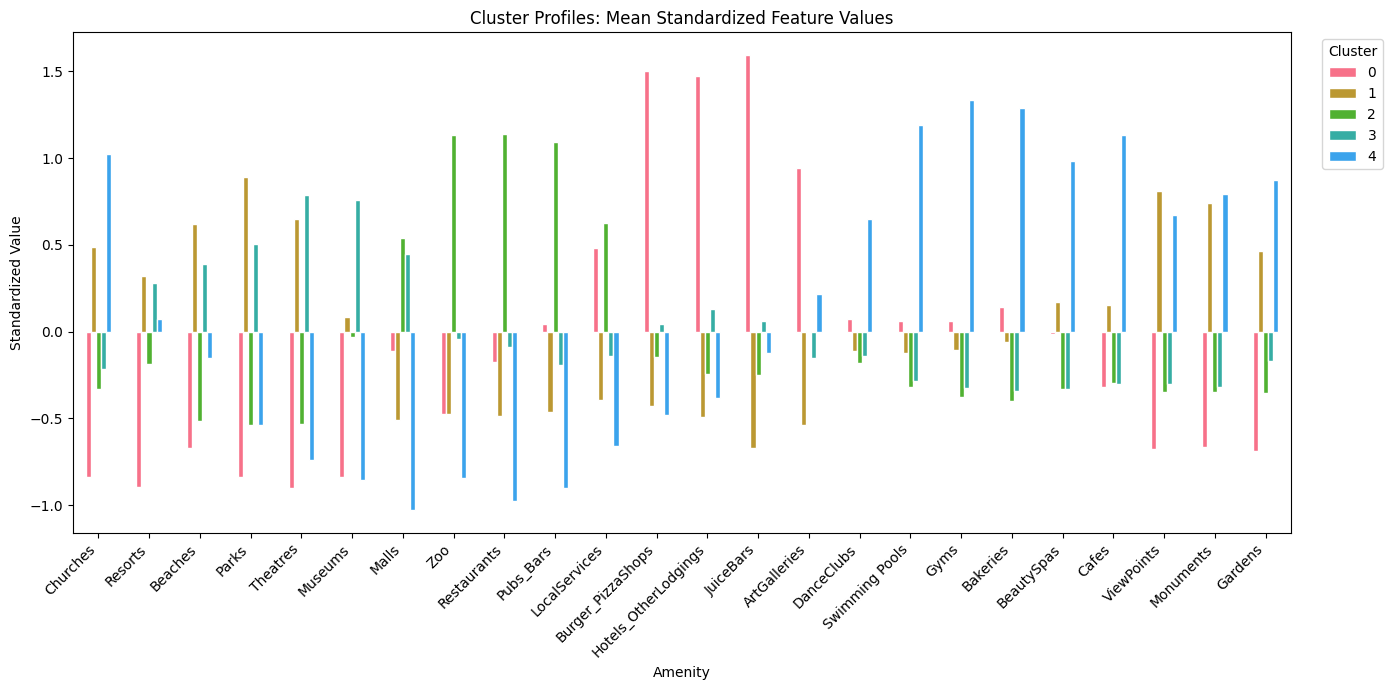

In [54]:
# Bar chart of cluster centers (Note: how far above or below average that cluster rates that amenity)
cluster_means.T.plot(kind="bar", figsize=(14, 7), edgecolor="white")
plt.title("Cluster Profiles: Mean Standardized Feature Values")
plt.ylabel("Standardized Value")
plt.xlabel("Amenity")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

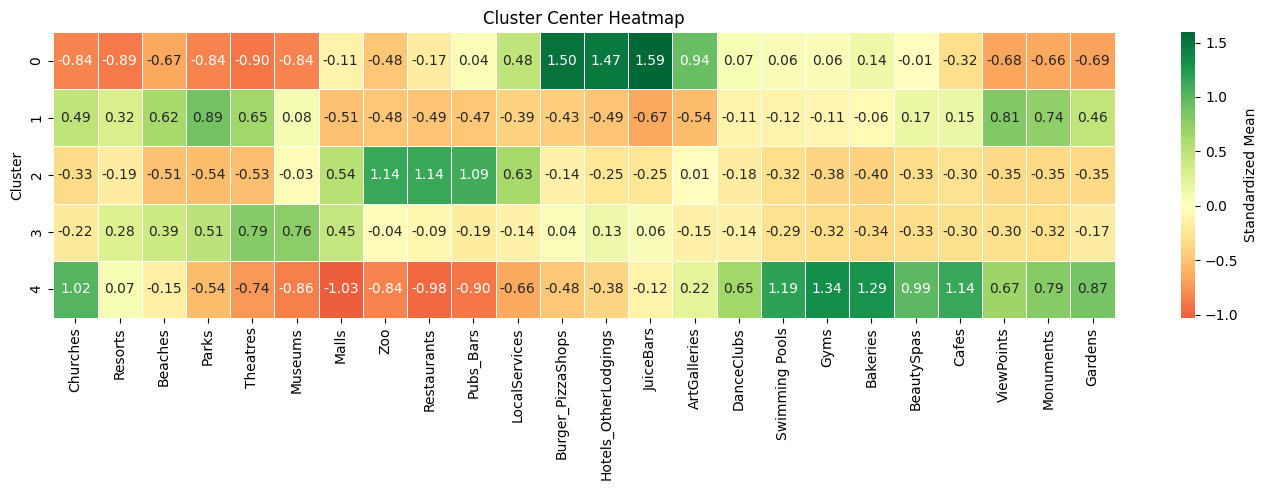

In [55]:
# Heatmap of cluster centers
# Note: Green/warm colors = above average, red/cool colors = below average; use this for interpretation
# START PROFILING HERE VISUALLY GREENS
plt.figure(figsize=(14, 5))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="RdYlGn", center=0,
            linewidths=0.5, cbar_kws={"label": "Standardized Mean"})
plt.title("Cluster Center Heatmap")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [56]:
# Cluster profiles in original (un-transformed) spending units
# Use for business interpretation
# Actual average ratings (0–5)
profile_orig = x_train.copy()
profile_orig["Cluster"] = train_labels

cluster_means_orig = profile_orig.groupby("Cluster")[rating_cols].mean() #rating columns edit

print("Cluster means in original spending units:")
display(cluster_means_orig.round(1))

Cluster means in original spending units:


Churches  Resorts  Beaches  Parks  Theatres  Museums  Malls  Zoo  \
Cluster                                                                     
0             0.8      1.0      1.7    1.7       1.7      1.8    3.2  2.0   
1             1.9      2.8      3.3    3.9       3.8      3.0    2.6  2.0   
2             1.2      2.1      1.8    2.1       2.2      2.8    4.1  3.8   
3             1.3      2.7      3.0    3.4       4.0      3.8    4.0  2.5   
4             2.3      2.4      2.3    2.1       2.0      1.8    1.9  1.6   

         Restaurants  Pubs_Bars  ...  ArtGalleries  DanceClubs  \
Cluster                          ...                             
0                2.9        2.9  ...           3.8         1.3   
1                2.5        2.2  ...           1.3         1.1   
2                4.7        4.3  ...           2.2         1.0   
3                3.0        2.6  ...           2.0         1.0   
4                1.8        1.7  ...           2.6         1.9   

         Swimming Pools  Gyms  Bakeries  BeautySpas  Cafes  ViewPoints  \
Cluster                                                                  
0                   1.0   0.9       1.1         1.0    0.7         0.7   
1                   0.8   0.7       0.9         1.2    1.1         3.0   
2                   0.6   0.5       0.5         0.6    0.7         1.2   
3                   0.7   0.5       0.6         0.6    0.7         1.3   
4                   2.1   2.0       2.5         2.2    2.0         2.8   

         Monuments  Gardens  
Cluster                      
0              0.6      0.7  
1              2.5      2.1  
2              1.1      1.1  
3              1.1      1.3  
4              2.5      2.5  

[5 rows x 24 columns]

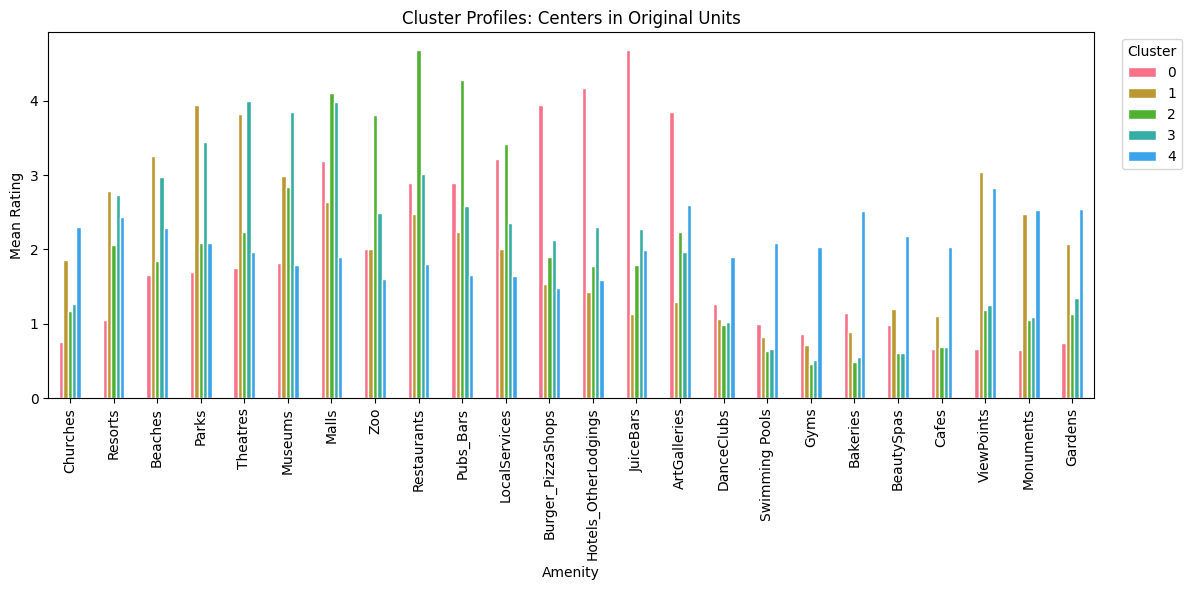

In [57]:
# Bar chart of profiles in original (un-transformed) spending units
# Average rating per cluster per amenity
# USE AS PRIMARY SEGMENT PROFILING TOOL
# For example, Cluster 0 Top 3: Burger/Pizza, JuiceBars, and Hotels together = Name??????
cluster_means_orig.T.plot(kind="bar", figsize=(12, 6), edgecolor="white")
plt.title("Cluster Profiles: Centers in Original Units")
plt.ylabel("Mean Rating")
plt.xlabel("Amenity")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

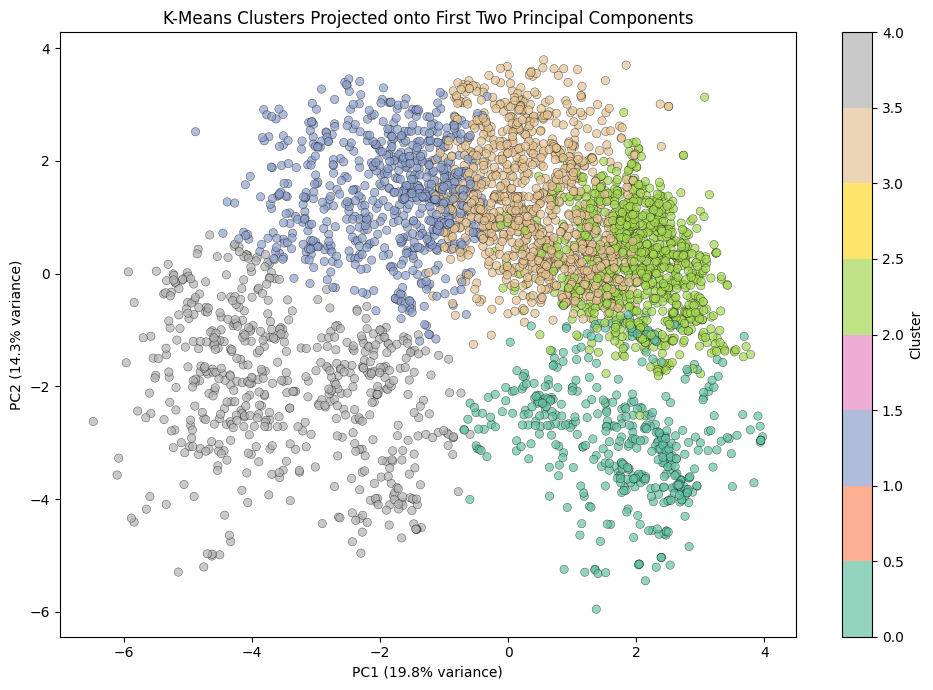

In [58]:
### 6b. Visual Inspection — PCA Projection
# OPAN_6603_Week_06_01_Example.ipynb
# Step 6b: PCA projection for visualization ----
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(x_train_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_labels,
                       cmap="Set2", alpha=0.7, edgecolors="k", linewidth=0.3)
plt.colorbar(scatter, label="Cluster")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.title("K-Means Clusters Projected onto First Two Principal Components")
plt.tight_layout()
plt.show()

In [59]:
### 6c. Supervised Augmentation — Multinomial Logistic Regression
# Logistic regression gives us coefficients (log-odds) that quantify how each feature shifts the probability of belonging to each cluster relative to a reference cluster.
# Step 6c -- Option B: Multinomial Logistic Regression ----

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr.fit(x_train_scaled, train_labels)

# Cross-validated accuracy
cv_scores_lr = cross_val_score(lr, x_train_scaled, train_labels, cv=5, scoring="accuracy")
print(f"Logistic Regression -- 5-fold CV Accuracy: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std():.3f})")

# Test set accuracy
test_acc_lr = lr.score(x_test_scaled, test_labels)
print(f"Logistic Regression -- Test Set Accuracy:  {test_acc_lr:.3f}")

Logistic Regression -- 5-fold CV Accuracy: 0.983 (+/- 0.004)
Logistic Regression -- Test Set Accuracy:  0.977


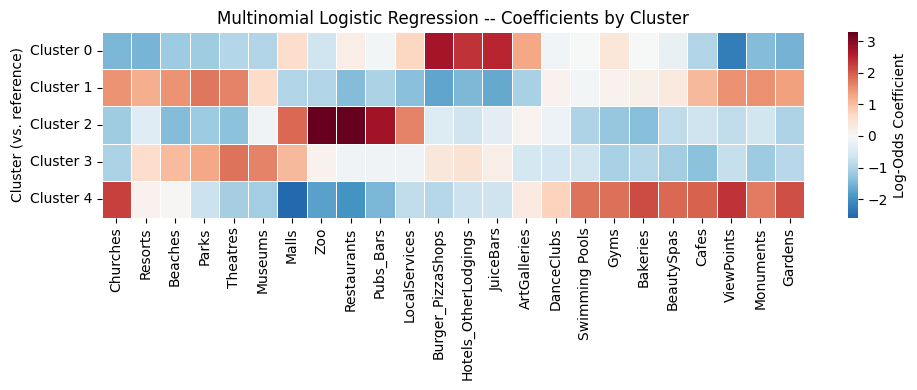

In [60]:
# Coefficients heatmap
# Assess in report section ---- ASSESS IN REPORT
coef_df = pd.DataFrame(lr.coef_, columns=rating_cols, # edit from original
                        index=[f"Cluster {i}" for i in range(k_chosen)])

plt.figure(figsize=(10, 4))
sns.heatmap(coef_df, annot=False, fmt=".2f", cmap="RdBu_r", center=0,
            linewidths=0.5, cbar_kws={"label": "Log-Odds Coefficient"})
plt.title("Multinomial Logistic Regression -- Coefficients by Cluster")
plt.ylabel("Cluster (vs. reference)")
plt.tight_layout()
plt.show()

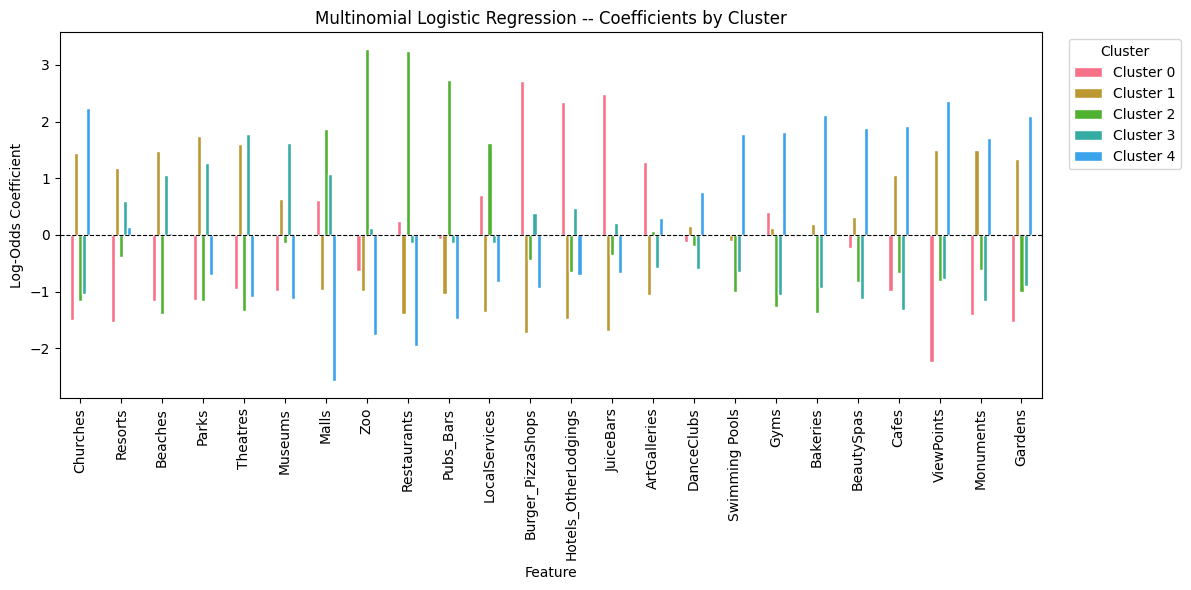

In [61]:
### # Coefficients bar chart
coef_df = pd.DataFrame(lr.coef_, columns=rating_cols,
                        index=[f"Cluster {i}" for i in range(k_chosen)])

coef_df.T.plot(kind="bar", figsize=(12, 6), edgecolor="white")
plt.title("Multinomial Logistic Regression -- Coefficients by Cluster")
plt.ylabel("Log-Odds Coefficient")
plt.xlabel("Feature")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [62]:
### From Dillon's code to get cluster sizes for targeting ; CELL # 46
print(pd.Series(train_labels).value_counts().sort_index())

0     453
1     723
2     959
3    1108
4     575
Name: count, dtype: int64


---
### 6d. Naming, Storytelling, and Actionability (EXAMPLE NB)

Based on the cluster profiles, Channel crosstab, supervised model, and domain knowledge, we assign business-meaningful names.

**Template** (fill in based on your results):

| Cluster | Proposed Name | Key Characteristics | Implied Action |
|---------|---------------|---------------------|----------------|
| 0 | *e.g., "Fresh-Focused Foodservice"* | High Fresh, low Grocery/Detergents | Targeted fresh produce promotions |
| 1 | *e.g., "Retail Grocery Buyers"* | High Grocery, Detergents_Paper, Milk | Bulk discount programs |
| 2 | *e.g., "Diversified Spenders"* | Moderate across categories | Cross-selling opportunities |

> **Key question:** What decisions change because of this segmentation? If no action changes, the analysis isn't finished.